## Projet 5 : Segmentez des clients d'un site e-commerce

## Contexte

Vous êtes consultant pour Olist, une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne.

Votre rôle est d’accompagner Olist dans leur projet de monter une équipe Data et leur premier cas d’usage Data Science autour de la segmentation client.

Première urgence : l'implémentation de requêtes SQL urgentes.

Deuxième urgence :  fournir aux équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Vous devrez fournir à l’équipe Marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

## Librairies utilisées avec le langage Python:

In [1]:
# Importation des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
def pd_to_sqlDB(input_df: pd.DataFrame,
                table_name: str,
                db_name: str = 'default.db') -> None:

    '''Take a Pandas dataframe `input_df` and upload it to `table_name` SQLITE table
    Args:
        input_df (pd.DataFrame): Dataframe containing data to upload to SQLITE
        table_name (str): Name of the SQLITE table to upload to
        db_name (str, optional): Name of the SQLITE Database in which the table is created.
                                 Defaults to 'default.db'.
    '''

    # Step 1: Setup local logging
    import logging
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s %(levelname)s: %(message)s',
                        datefmt='%Y-%m-%d %H:%M:%S')

    # Step 2: Find columns in the dataframe
    cols = input_df.columns
    cols_string = ','.join(cols)
    val_wildcard_string = ','.join(['?'] * len(cols))

    # Step 3: Connect to a DB file if it exists, else crete a new file
    con = sqlite3.connect(db_name)
    cur = con.cursor()
    logging.info(f'SQL DB {db_name} created')

    # Step 4: Create Table
    sql_string = f"""CREATE TABLE {table_name} ({cols_string});"""
    cur.execute(sql_string)
    logging.info(f'SQL Table {table_name} created with {len(cols)} columns')

    # Step 5: Upload the dataframe
    rows_to_upload = input_df.to_dict(orient='split')['data']
    sql_string = f"""INSERT INTO {table_name} ({cols_string}) VALUES ({val_wildcard_string});"""
    cur.executemany(sql_string, rows_to_upload)
    logging.info(f'{len(rows_to_upload)} rows uploaded to {table_name}')

    # Step 6: Commit the changes and close the connection
    con.commit()
    con.close()

In [3]:
def sql_query_to_pd(sql_query_string: str, db_name: str ='default.db') -> pd.DataFrame:
    '''Execute an SQL query and return the results as a pandas dataframe
    Args:
        sql_query_string (str): SQL query string to execute
        db_name (str, optional): Name of the SQLITE Database to execute the query in.
                                 Defaults to 'default.db'.
    Returns:
        pd.DataFrame: Results of the SQL query in a pandas dataframe
    '''
    # Step 1: Connect to the SQL DB
    con = sqlite3.connect(db_name)

    # Step 2: Execute the SQL query
    cursor = con.execute(sql_query_string)

    # Step 3: Fetch the data and column names
    result_data = cursor.fetchall()
    cols = [description[0] for description in cursor.description]

    # Step 4: Close the connection
    con.close()

    # Step 5: Return as a dataframe
    return pd.DataFrame(result_data, columns=cols)

## Requête SQL

voir script

## Données brutes:

Le schema de données nous est donné :

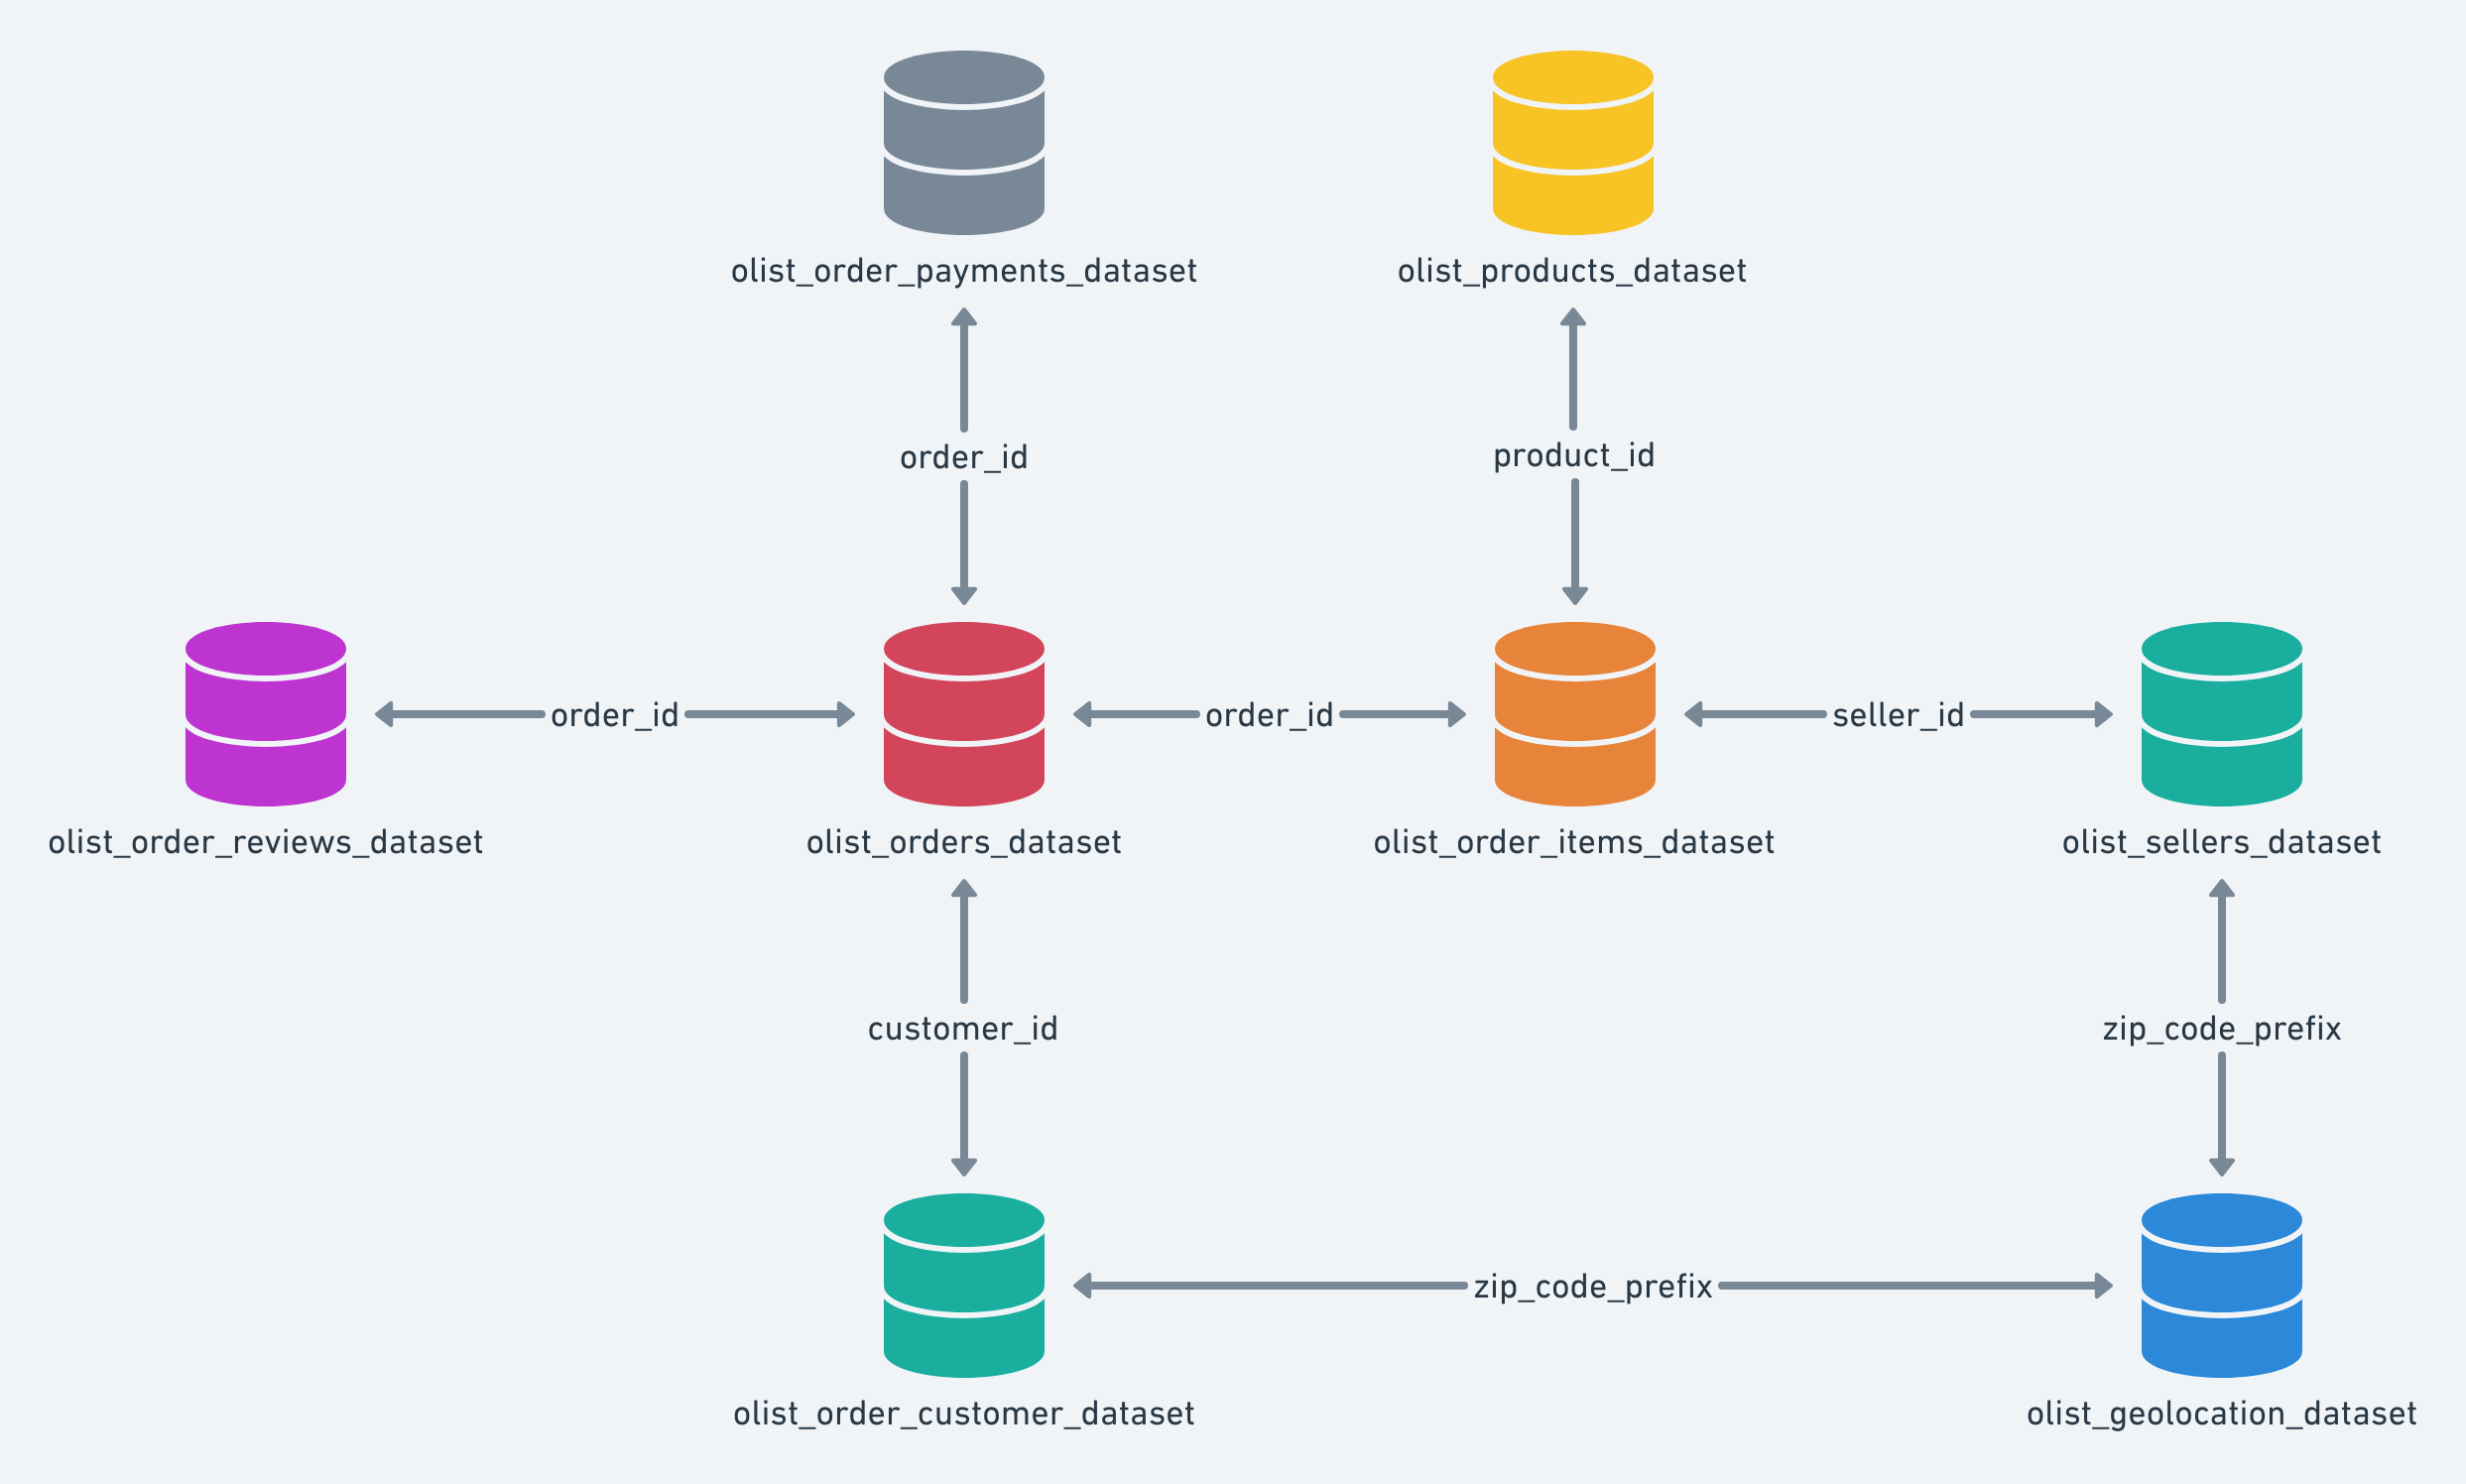

Nous allons récupérer ces données, les analyser et créer un dataframe contenant une ligne par client  pour préparer le clustering.

In [4]:
# Chargement des données brutes du fichier CSV
customers = pd.read_csv('/tutorial-env/OCR/Projet5/data/olist_customers_dataset.csv')
geolocation = pd.read_csv('/tutorial-env/OCR/Projet5/data/olist_geolocation_dataset.csv')
order_items = pd.read_csv('/tutorial-env/OCR/Projet5/data/olist_order_items_dataset.csv')
order_payments = pd.read_csv('/tutorial-env/OCR/Projet5/data/olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('/tutorial-env/OCR/Projet5/data/olist_order_reviews_dataset.csv')
orders = pd.read_csv('/tutorial-env/OCR/Projet5/data/olist_orders_dataset.csv')
products = pd.read_csv('/tutorial-env/OCR/Projet5/data/olist_products_dataset.csv')
sellers = pd.read_csv('/tutorial-env/OCR/Projet5/data/olist_sellers_dataset.csv')
product_transalation = pd.read_csv('/tutorial-env/OCR/Projet5/data/product_category_name_translation.csv')


In [5]:
# Dataframe orders
print(f"Dimensions de orders : {orders.shape}")

print('--'*50)

print(f"Colonnes et pourcentage de valeurs manquantes :\n")
print(orders.isna().mean())

print('--'*50)

print(f"Type de données:\n")
print(orders.dtypes)

print('--'*50)

# Recherche de doublons :
print(f"Il y a {orders.duplicated().sum()} lignes en doublons")

Dimensions de orders : (99441, 8)
----------------------------------------------------------------------------------------------------
Colonnes et pourcentage de valeurs manquantes :

order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.001609
order_delivered_carrier_date     0.017930
order_delivered_customer_date    0.029817
order_estimated_delivery_date    0.000000
dtype: float64
----------------------------------------------------------------------------------------------------
Type de données:

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object
------------

Nous garderons la totalité de ces variables dans le dataframe final, excepté "order_approved_at" et "order_delivered_carrier_date".

Nous enlèverons les heures des timestamps et garderons l'heure et le jour de la semaine  de la date de commande dans des colonnes séparées.

In [6]:
# Upload the dataframe to a SQL Table
pd_to_sqlDB(orders,
            table_name='orders_CL',
            db_name='/tutorial-env/OCR/Projet5/olist.db')

# Step 3: Write the SQL query in a string variable
sql_query_string = """
SELECT customer_id, order_id, order_status, DATE(order_purchase_timestamp) AS order_purchase_date,strftime('%m',order_purchase_timestamp) AS order_purchase_month, strftime('%w',order_purchase_timestamp) AS order_purchase_day,strftime('%H',order_purchase_timestamp) AS order_purchase_hour,DATE(order_estimated_delivery_date) AS order_estimated_delivery_date,DATE(order_delivered_customer_date) AS order_delivered_customer_date
FROM orders
ORDER BY 1,2,3,4
"""

# Step 4: Exectue the SQL query
df_temp=sql_query_to_pd(sql_query_string, db_name='/tutorial-env/OCR/Projet5/olist.db')
df_temp

2024-09-27 11:30:29 INFO: SQL DB /tutorial-env/OCR/Projet5/olist.db created
2024-09-27 11:30:29 INFO: SQL Table orders_CL created with 8 columns
2024-09-27 11:30:31 INFO: 99441 rows uploaded to orders_CL


customer_id                          order_id  \
0      00012a2ce6f8dcda20d059ce98491703  5f79b5b0931d63f1a42989eb65b9da6e   
1      000161a058600d5901f007fab4c27140  a44895d095d7e0702b6a162fa2dbeced   
2      0001fd6190edaaf884bcaf3d49edf079  316a104623542e4d75189bb372bc5f8d   
3      0002414f95344307404f0ace7a26f1d5  5825ce2e88d5346438686b0bba99e5ee   
4      000379cdec625522490c315e70c7a9fb  0ab7fb08086d4af9141453c91878ed7a   
...                                 ...                               ...   
99436  fffecc9f79fd8c764f843e9951b11341  814d6a3a7c0b32b2ad929ac6328124e9   
99437  fffeda5b6d849fbd39689bb92087f431  8c855550908247a7eff50281b92167a8   
99438  ffff42319e9b2d713724ae527742af25  83b5fc912b2862c5046555ded1483ae9   
99439  ffffa3172527f765de70084a7e53aae8  d0e7be325a1c986babc4e1cdb91edc03   
99440  ffffe8b65bbe3087b653a978c870db99  2e935fa1d39497aa0ec3f1107fbfb5b8   

      order_status order_purchase_date order_purchase_month  \
0        delivered          2017-11-14                   11   
1        delivered          2017-07-16                   07   
2        delivered          2017-02-28                   02   
3        delivered          2017-08-16                   08   
4        delivered          2018-04-02                   04   
...            ...                 ...                  ...   
99436    delivered          2018-03-29                   03   
99437    delivered          2018-05-22                   05   
99438    delivered          2018-06-13                   06   
99439    delivered          2017-09-02                   09   
99440  unavailable          2017-09-29                   09   

      order_purchase_day order_purchase_hour order_estimated_delivery_date  \
0                      2                  16                    2017-12-04   
1                      0                  09                    2017-08-04   
2                      2                  11                    2017-03-22   
3                      3                  13                    2017-09-14   
4                      1                  13                    2018-04-18   
...                  ...                 ...                           ...   
99436                  4                  16                    2018-04-27   
99437                  2                  13                    2018-06-29   
99438                  3                  16                    2018-06-25   
99439                  6                  11                    2017-09-26   
99440                  5                  14                    2017-10-24   

      order_delivered_customer_date  
0                        2017-11-28  
1                        2017-07-25  
2                        2017-03-06  
3                        2017-09-13  
4                        2018-04-13  
...                             ...  
99436                    2018-04-10  
99437                    2018-06-08  
99438                    2018-06-18  
99439                    2017-09-14  
99440                          None  

[99441 rows x 9 columns]

In [7]:
# Création du dataframe data :
data = pd.DataFrame(df_temp)

In [8]:
data.head(5)

customer_id                          order_id  \
0  00012a2ce6f8dcda20d059ce98491703  5f79b5b0931d63f1a42989eb65b9da6e   
1  000161a058600d5901f007fab4c27140  a44895d095d7e0702b6a162fa2dbeced   
2  0001fd6190edaaf884bcaf3d49edf079  316a104623542e4d75189bb372bc5f8d   
3  0002414f95344307404f0ace7a26f1d5  5825ce2e88d5346438686b0bba99e5ee   
4  000379cdec625522490c315e70c7a9fb  0ab7fb08086d4af9141453c91878ed7a   

  order_status order_purchase_date order_purchase_month order_purchase_day  \
0    delivered          2017-11-14                   11                  2   
1    delivered          2017-07-16                   07                  0   
2    delivered          2017-02-28                   02                  2   
3    delivered          2017-08-16                   08                  3   
4    delivered          2018-04-02                   04                  1   

  order_purchase_hour order_estimated_delivery_date  \
0                  16                    2017-12-04   
1                  09                    2017-08-04   
2                  11                    2017-03-22   
3                  13                    2017-09-14   
4                  13                    2018-04-18   

  order_delivered_customer_date  
0                    2017-11-28  
1                    2017-07-25  
2                    2017-03-06  
3                    2017-09-13  
4                    2018-04-13

In [9]:
# Dataframe customers
print(f"Dimensions de customers : {customers.shape}")

print('--'*50)

print(f"Colonnes et pourcentage de valeurs manquantes :\n")
print(customers.isna().mean())

print('--'*50)

print(f"Type de données:\n")
print(customers.dtypes)

print('--'*50)

# Recherche de doublons :
print(f"Il y a {customers.duplicated().sum()} lignes en doublons")


Dimensions de customers : (99441, 5)
----------------------------------------------------------------------------------------------------
Colonnes et pourcentage de valeurs manquantes :

customer_id                 0.0
customer_unique_id          0.0
customer_zip_code_prefix    0.0
customer_city               0.0
customer_state              0.0
dtype: float64
----------------------------------------------------------------------------------------------------
Type de données:

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object
----------------------------------------------------------------------------------------------------
Il y a 0 lignes en doublons


Nous garderons la totalité de ces variables dans le dataframe final.

In [10]:
# Ajout des colonnes à data :
data = data.merge(customers[['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city','customer_state']], on='customer_id', how='left')

# Chagement de type de la colonne order_purchase_timestamp :
data['customer_zip_code_prefix'] = data['customer_zip_code_prefix'].astype('object')

data.head(5)

customer_id                          order_id  \
0  00012a2ce6f8dcda20d059ce98491703  5f79b5b0931d63f1a42989eb65b9da6e   
1  000161a058600d5901f007fab4c27140  a44895d095d7e0702b6a162fa2dbeced   
2  0001fd6190edaaf884bcaf3d49edf079  316a104623542e4d75189bb372bc5f8d   
3  0002414f95344307404f0ace7a26f1d5  5825ce2e88d5346438686b0bba99e5ee   
4  000379cdec625522490c315e70c7a9fb  0ab7fb08086d4af9141453c91878ed7a   

  order_status order_purchase_date order_purchase_month order_purchase_day  \
0    delivered          2017-11-14                   11                  2   
1    delivered          2017-07-16                   07                  0   
2    delivered          2017-02-28                   02                  2   
3    delivered          2017-08-16                   08                  3   
4    delivered          2018-04-02                   04                  1   

  order_purchase_hour order_estimated_delivery_date  \
0                  16                    2017-12-04   
1                  09                    2017-08-04   
2                  11                    2017-03-22   
3                  13                    2017-09-14   
4                  13                    2018-04-18   

  order_delivered_customer_date                customer_unique_id  \
0                    2017-11-28  248ffe10d632bebe4f7267f1f44844c9   
1                    2017-07-25  b0015e09bb4b6e47c52844fab5fb6638   
2                    2017-03-06  94b11d37cd61cb2994a194d11f89682b   
3                    2017-09-13  4893ad4ea28b2c5b3ddf4e82e79db9e6   
4                    2018-04-13  0b83f73b19c2019e182fd552c048a22c   

  customer_zip_code_prefix customer_city customer_state  
0                     6273        osasco             SP  
1                    35550   itapecerica             MG  
2                    29830  nova venecia             ES  
3                    39664      mendonca             MG  
4                     4841     sao paulo             SP

In [11]:
# Dataframe geolocation
print(f"Dimensions de geolocation : {geolocation.shape}")

print('--'*50)

print(f"Colonnes et pourcentage de valeurs manquantes :\n")
print(geolocation.isna().mean())

print('--'*50)

print(f"Type de données:\n")
print(geolocation.dtypes)

print('--'*50)

# Recherche de doublons :
print(f"Il y a {geolocation.duplicated().sum()} lignes en doublons")


Dimensions de geolocation : (1000163, 5)
----------------------------------------------------------------------------------------------------
Colonnes et pourcentage de valeurs manquantes :

geolocation_zip_code_prefix    0.0
geolocation_lat                0.0
geolocation_lng                0.0
geolocation_city               0.0
geolocation_state              0.0
dtype: float64
----------------------------------------------------------------------------------------------------
Type de données:

geolocation_zip_code_prefix      int64
geolocation_lat                float64
geolocation_lng                float64
geolocation_city                object
geolocation_state               object
dtype: object
----------------------------------------------------------------------------------------------------
Il y a 261831 lignes en doublons


Il y a un grand nombre de doublons.

Un préfixe est lié à une ville et un état mais plusieurs latitudes/longitudes.

Les latitudes et longitudes ne nous sont pas utiles, nous ne garderons donc pas les variables de cette table.

In [12]:
# Dataframe order_items
print(f"Dimensions de order_items : {order_items.shape}")

print('--'*50)

print(f"Colonnes et pourcentage de valeurs manquantes :\n")
print(order_items.isna().mean())

print('--'*50)

print(f"Type de données:\n")
print(order_items.dtypes)

print('--'*50)

# Recherche de doublons :
print(f"Il y a {order_items.duplicated().sum()} lignes en doublons")

Dimensions de order_items : (112650, 7)
----------------------------------------------------------------------------------------------------
Colonnes et pourcentage de valeurs manquantes :

order_id               0.0
order_item_id          0.0
product_id             0.0
seller_id              0.0
shipping_limit_date    0.0
price                  0.0
freight_value          0.0
dtype: float64
----------------------------------------------------------------------------------------------------
Type de données:

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object
----------------------------------------------------------------------------------------------------
Il y a 0 lignes en doublons


Nous garderons la totalité de ces variables dans le dataframe final, excepté "shipping_limit_date" et "freight_value".

In [13]:
#  Upload the dataframe to a SQL Table
pd_to_sqlDB(order_items,
            table_name='order_item_CL',
            db_name='/tutorial-env/OCR/Projet5/olist.db')

# Write the SQL query in a string variable
sql_query_string = """
SELECt DISTINCT order_id,FIRST_VALUE(product_id) OVER(PARTITION BY order_id ORDER BY order_item_id DESC) AS principal_product, FIRST_VALUE(seller_id) OVER(PARTITION BY order_id ORDER BY order_item_id DESC) AS seller_id,FIRST_VALUE(order_item_id) OVER(PARTITION BY order_id ORDER BY order_item_id DESC) AS max_item,
FIRST_VALUE(price) OVER(PARTITION BY order_id ORDER BY order_item_id DESC) AS price, FIRST_VALUE(freight_value) OVER(PARTITION BY order_id ORDER BY order_item_id DESC) AS freight_value
FROM order_item_CL
ORDER BY 1,2,3
"""

# Exectue the SQL query
df_temp=sql_query_to_pd(sql_query_string, db_name='/tutorial-env/OCR/Projet5/olist.db')
df_temp

2024-09-27 11:30:37 INFO: SQL DB /tutorial-env/OCR/Projet5/olist.db created
2024-09-27 11:30:37 INFO: SQL Table order_item_CL created with 7 columns
2024-09-27 11:30:38 INFO: 112650 rows uploaded to order_item_CL


order_id                 principal_product  \
0      00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1      00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2      000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3      00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4      00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   
...                                 ...                               ...   
98661  fffc94f6ce00a00581880bf54a75a037  4aa6014eceb682077f9dc4bffebc05b0   
98662  fffcd46ef2263f404302a634eb57f7eb  32e07fd915822b0765e448c4dd74c828   
98663  fffce4705a9662cd70adb13d4a31832d  72a30483855e2eafc67aee5dc2560482   
98664  fffe18544ffabc95dfada21779c9644f  9c422a519119dcad7575db5af1ba540e   
98665  fffe41c64501cc87c801fd61db3f6244  350688d9dc1e75ff97be326363655e01   

                              seller_id  max_item   price  freight_value  
0      48436dade18ac8b2bce089ec2a041202         1   58.90          13.29  
1      dd7ddc04e1b6c2c614352b383efe2d36         1  239.90          19.93  
2      5b51032eddd242adc84c38acab88f23d         1  199.00          17.87  
3      9d7a1d34a5052409006425275ba1c2b4         1   12.99          12.79  
4      df560393f3a51e74553ab94004ba5c87         1  199.90          18.14  
...                                 ...       ...     ...            ...  
98661  b8bc237ba3788b23da09c0f1f3a3288c         1  299.99          43.41  
98662  f3c38ab652836d21de61fb8314b69182         1  350.00          36.53  
98663  c3cfdc648177fdbbbb35635a37472c53         1   99.90          16.95  
98664  2b3e4a2a3ea8e01938cabda2a3e5cc79         1   55.99           8.72  
98665  f7ccf836d21b2fb1de37564105216cc1         1   43.00          12.79  

[98666 rows x 6 columns]

In [14]:
# Ajout des colonnes à data :
data = data.merge(df_temp[['order_id', 'principal_product','seller_id','max_item', 'price','freight_value']], on='order_id', how='left')

data.head(5)

customer_id                          order_id  \
0  00012a2ce6f8dcda20d059ce98491703  5f79b5b0931d63f1a42989eb65b9da6e   
1  000161a058600d5901f007fab4c27140  a44895d095d7e0702b6a162fa2dbeced   
2  0001fd6190edaaf884bcaf3d49edf079  316a104623542e4d75189bb372bc5f8d   
3  0002414f95344307404f0ace7a26f1d5  5825ce2e88d5346438686b0bba99e5ee   
4  000379cdec625522490c315e70c7a9fb  0ab7fb08086d4af9141453c91878ed7a   

  order_status order_purchase_date order_purchase_month order_purchase_day  \
0    delivered          2017-11-14                   11                  2   
1    delivered          2017-07-16                   07                  0   
2    delivered          2017-02-28                   02                  2   
3    delivered          2017-08-16                   08                  3   
4    delivered          2018-04-02                   04                  1   

  order_purchase_hour order_estimated_delivery_date  \
0                  16                    2017-12-04   
1                  09                    2017-08-04   
2                  11                    2017-03-22   
3                  13                    2017-09-14   
4                  13                    2018-04-18   

  order_delivered_customer_date                customer_unique_id  \
0                    2017-11-28  248ffe10d632bebe4f7267f1f44844c9   
1                    2017-07-25  b0015e09bb4b6e47c52844fab5fb6638   
2                    2017-03-06  94b11d37cd61cb2994a194d11f89682b   
3                    2017-09-13  4893ad4ea28b2c5b3ddf4e82e79db9e6   
4                    2018-04-13  0b83f73b19c2019e182fd552c048a22c   

  customer_zip_code_prefix customer_city customer_state  \
0                     6273        osasco             SP   
1                    35550   itapecerica             MG   
2                    29830  nova venecia             ES   
3                    39664      mendonca             MG   
4                     4841     sao paulo             SP   

                  principal_product                         seller_id  \
0  64315bd8c0c47303179dd2e25b579d00  7aa4334be125fcdd2ba64b3180029f14   
1  84183944dc7cddca87a5d384452c1d3c  2a1348e9addc1af5aaa619b1a3679d6b   
2  9df2b21ec85378d71df4404712e17478  46dc3b2cc0980fb8ec44634e21d2718e   
3  af3ec22cce878225aae6d9eb6c7a78eb  aafe36600ce604f205b86b5084d3d767   
4  868b3136c5b206f91b8208fbfdf2cb7c  4a3ca9315b744ce9f8e9374361493884   

   max_item   price  freight_value  
0       1.0   89.80          24.94  
1       1.0   54.90          12.51  
2       1.0  179.99          15.43  
3       1.0  149.90          29.45  
4       1.0   93.00          14.01

In [15]:
data.shape

(99441, 18)

In [16]:
# Dataframe order_payments
print(f"Dimensions de order_payments : {order_payments.shape}")

print('--'*50)

print(f"Colonnes et pourcentage de valeurs manquantes :\n")
print(order_payments.isna().mean())

print('--'*50)

print(f"Type de données:\n")
print(order_payments.dtypes)

print('--'*50)

# Recherche de doublons :
print(f"Il y a {order_payments.duplicated().sum()} lignes en doublons")

Dimensions de order_payments : (103886, 5)
----------------------------------------------------------------------------------------------------
Colonnes et pourcentage de valeurs manquantes :

order_id                0.0
payment_sequential      0.0
payment_type            0.0
payment_installments    0.0
payment_value           0.0
dtype: float64
----------------------------------------------------------------------------------------------------
Type de données:

order_id                 object
payment_sequential        int64
payment_type             object
payment_installments      int64
payment_value           float64
dtype: object
----------------------------------------------------------------------------------------------------
Il y a 0 lignes en doublons


Nous garderons la totalité de ces variables dans le dataframe final, excepté "payment_sequential".

In [17]:
# Création d'une table pivot pour les paiements:
payments_pivot = pd.pivot_table(
    order_payments,
    values='payment_value',
    index='order_id',
    columns='payment_type',
    aggfunc='sum',
    fill_value=0
)

# Réinitialisation de l'index :
payments_pivot = payments_pivot.reset_index()

# Ajout de la colonne payment_total
payments_pivot['total'] = payments_pivot.iloc[:, 1:].sum(axis=1)

# Report de la colonne installments de payments :
payments_installments = order_payments.groupby('order_id')['payment_installments'].first().reset_index()

# Fusion de payments_pivot et payment_installments :
payments = pd.merge(payments_pivot, payments_installments, on='order_id')

# Renommage des colonnes en ajoutant "payment_" devant chaque nom de colonne de type de paiement :
payments.rename(columns=lambda x: f"payment_{x}" if x != 'order_id' else x, inplace=True)

payments

order_id  payment_boleto  payment_credit_card  \
0      00010242fe8c5a6d1ba2dd792cb16214            0.00                72.19   
1      00018f77f2f0320c557190d7a144bdd3            0.00               259.83   
2      000229ec398224ef6ca0657da4fc703e            0.00               216.87   
3      00024acbcdf0a6daa1e931b038114c75            0.00                25.78   
4      00042b26cf59d7ce69dfabb4e55b4fd9            0.00               218.04   
...                                 ...             ...                  ...   
99435  fffc94f6ce00a00581880bf54a75a037          343.40                 0.00   
99436  fffcd46ef2263f404302a634eb57f7eb          386.53                 0.00   
99437  fffce4705a9662cd70adb13d4a31832d            0.00               116.85   
99438  fffe18544ffabc95dfada21779c9644f            0.00                64.71   
99439  fffe41c64501cc87c801fd61db3f6244            0.00                55.79   

       payment_debit_card  payment_not_defined  payment_voucher  \
0                     0.0                  0.0              0.0   
1                     0.0                  0.0              0.0   
2                     0.0                  0.0              0.0   
3                     0.0                  0.0              0.0   
4                     0.0                  0.0              0.0   
...                   ...                  ...              ...   
99435                 0.0                  0.0              0.0   
99436                 0.0                  0.0              0.0   
99437                 0.0                  0.0              0.0   
99438                 0.0                  0.0              0.0   
99439                 0.0                  0.0              0.0   

       payment_total  payment_payment_installments  
0              72.19                             2  
1             259.83                             3  
2             216.87                             5  
3              25.78                             2  
4             218.04                             3  
...              ...                           ...  
99435         343.40                             1  
99436         386.53                             1  
99437         116.85                             3  
99438          64.71                             3  
99439          55.79                             1  

[99440 rows x 8 columns]

In [18]:
# Ajout des colonnes à data :
data = data.merge(payments[['order_id', 'payment_boleto','payment_credit_card','payment_debit_card', 'payment_not_defined','payment_voucher','payment_total','payment_payment_installments']], on='order_id', how='left')

data.head(5)

customer_id                          order_id  \
0  00012a2ce6f8dcda20d059ce98491703  5f79b5b0931d63f1a42989eb65b9da6e   
1  000161a058600d5901f007fab4c27140  a44895d095d7e0702b6a162fa2dbeced   
2  0001fd6190edaaf884bcaf3d49edf079  316a104623542e4d75189bb372bc5f8d   
3  0002414f95344307404f0ace7a26f1d5  5825ce2e88d5346438686b0bba99e5ee   
4  000379cdec625522490c315e70c7a9fb  0ab7fb08086d4af9141453c91878ed7a   

  order_status order_purchase_date order_purchase_month order_purchase_day  \
0    delivered          2017-11-14                   11                  2   
1    delivered          2017-07-16                   07                  0   
2    delivered          2017-02-28                   02                  2   
3    delivered          2017-08-16                   08                  3   
4    delivered          2018-04-02                   04                  1   

  order_purchase_hour order_estimated_delivery_date  \
0                  16                    2017-12-04   
1                  09                    2017-08-04   
2                  11                    2017-03-22   
3                  13                    2017-09-14   
4                  13                    2018-04-18   

  order_delivered_customer_date                customer_unique_id  ...  \
0                    2017-11-28  248ffe10d632bebe4f7267f1f44844c9  ...   
1                    2017-07-25  b0015e09bb4b6e47c52844fab5fb6638  ...   
2                    2017-03-06  94b11d37cd61cb2994a194d11f89682b  ...   
3                    2017-09-13  4893ad4ea28b2c5b3ddf4e82e79db9e6  ...   
4                    2018-04-13  0b83f73b19c2019e182fd552c048a22c  ...   

  max_item   price freight_value payment_boleto payment_credit_card  \
0      1.0   89.80         24.94           0.00              114.74   
1      1.0   54.90         12.51           0.00               67.41   
2      1.0  179.99         15.43           0.00              195.42   
3      1.0  149.90         29.45         179.35                0.00   
4      1.0   93.00         14.01         107.01                0.00   

   payment_debit_card  payment_not_defined  payment_voucher  payment_total  \
0                 0.0                  0.0              0.0         114.74   
1                 0.0                  0.0              0.0          67.41   
2                 0.0                  0.0              0.0         195.42   
3                 0.0                  0.0              0.0         179.35   
4                 0.0                  0.0              0.0         107.01   

   payment_payment_installments  
0                           8.0  
1                           5.0  
2                          10.0  
3                           1.0  
4                           1.0  

[5 rows x 25 columns]

In [19]:
data.shape

(99441, 25)

In [20]:
# Dataframe order_reviews
print(f"Dimensions de order_reviews : {order_reviews.shape}")

print('--'*50)

print(f"Colonnes et pourcentage de valeurs manquantes :\n")
print(order_reviews.isna().mean())

print('--'*50)

print(f"Type de données:\n")
print(order_reviews.dtypes)

print('--'*50)

# Recherche de doublons :
print(f"Il y a {order_reviews.duplicated().sum()} lignes en doublons")

Dimensions de order_reviews : (99224, 7)
----------------------------------------------------------------------------------------------------
Colonnes et pourcentage de valeurs manquantes :

review_id                  0.000000
order_id                   0.000000
review_score               0.000000
review_comment_title       0.883415
review_comment_message     0.587025
review_creation_date       0.000000
review_answer_timestamp    0.000000
dtype: float64
----------------------------------------------------------------------------------------------------
Type de données:

review_id                  object
order_id                   object
review_score                int64
review_comment_title       object
review_comment_message     object
review_creation_date       object
review_answer_timestamp    object
dtype: object
----------------------------------------------------------------------------------------------------
Il y a 0 lignes en doublons


Nous garderons les variables "review_id" et "review_score " dans le dataframe final.

In [21]:
# Création de la moyenne des revues :
order_reviews = order_reviews[['order_id', 'review_score']]
order_reviews = order_reviews.groupby('order_id').mean()

# Arrondissement des valeurs de la colonne 'review_score' :
order_reviews['review_score'] = round(order_reviews['review_score'])

# Renommage de la colonne 'review_score' :
order_reviews.rename(columns={'review_score' : 'review_score_moy'}, inplace=True)

# Reset de l'index :
order_reviews = order_reviews.reset_index()

In [22]:
# Ajout des colonnes à data :
data = data.merge(order_reviews[['order_id', 'review_score_moy']], on='order_id', how='left')

data.head(5)

customer_id                          order_id  \
0  00012a2ce6f8dcda20d059ce98491703  5f79b5b0931d63f1a42989eb65b9da6e   
1  000161a058600d5901f007fab4c27140  a44895d095d7e0702b6a162fa2dbeced   
2  0001fd6190edaaf884bcaf3d49edf079  316a104623542e4d75189bb372bc5f8d   
3  0002414f95344307404f0ace7a26f1d5  5825ce2e88d5346438686b0bba99e5ee   
4  000379cdec625522490c315e70c7a9fb  0ab7fb08086d4af9141453c91878ed7a   

  order_status order_purchase_date order_purchase_month order_purchase_day  \
0    delivered          2017-11-14                   11                  2   
1    delivered          2017-07-16                   07                  0   
2    delivered          2017-02-28                   02                  2   
3    delivered          2017-08-16                   08                  3   
4    delivered          2018-04-02                   04                  1   

  order_purchase_hour order_estimated_delivery_date  \
0                  16                    2017-12-04   
1                  09                    2017-08-04   
2                  11                    2017-03-22   
3                  13                    2017-09-14   
4                  13                    2018-04-18   

  order_delivered_customer_date                customer_unique_id  ...  \
0                    2017-11-28  248ffe10d632bebe4f7267f1f44844c9  ...   
1                    2017-07-25  b0015e09bb4b6e47c52844fab5fb6638  ...   
2                    2017-03-06  94b11d37cd61cb2994a194d11f89682b  ...   
3                    2017-09-13  4893ad4ea28b2c5b3ddf4e82e79db9e6  ...   
4                    2018-04-13  0b83f73b19c2019e182fd552c048a22c  ...   

    price freight_value payment_boleto payment_credit_card payment_debit_card  \
0   89.80         24.94           0.00              114.74                0.0   
1   54.90         12.51           0.00               67.41                0.0   
2  179.99         15.43           0.00              195.42                0.0   
3  149.90         29.45         179.35                0.00                0.0   
4   93.00         14.01         107.01                0.00                0.0   

   payment_not_defined  payment_voucher  payment_total  \
0                  0.0              0.0         114.74   
1                  0.0              0.0          67.41   
2                  0.0              0.0         195.42   
3                  0.0              0.0         179.35   
4                  0.0              0.0         107.01   

   payment_payment_installments  review_score_moy  
0                           8.0               1.0  
1                           5.0               4.0  
2                          10.0               5.0  
3                           1.0               5.0  
4                           1.0               4.0  

[5 rows x 26 columns]

In [23]:
data.shape

(99441, 26)

In [24]:
# Dataframe products
print(f"Dimensions de products : {products.shape}")

print('--'*50)

print(f"Colonnes et pourcentage de valeurs manquantes :\n")
print(products.isna().mean())

print('--'*50)

print(f"Type de données:\n")
print(products.dtypes)

print('--'*50)

# Recherche de doublons :
print(f"Il y a {products.duplicated().sum()} lignes en doublons")

Dimensions de products : (32951, 9)
----------------------------------------------------------------------------------------------------
Colonnes et pourcentage de valeurs manquantes :

product_id                    0.000000
product_category_name         0.018512
product_name_lenght           0.018512
product_description_lenght    0.018512
product_photos_qty            0.018512
product_weight_g              0.000061
product_length_cm             0.000061
product_height_cm             0.000061
product_width_cm              0.000061
dtype: float64
----------------------------------------------------------------------------------------------------
Type de données:

product_id                     object
product_category_name          object
product_name_lenght           float64
product_description_lenght    float64
product_photos_qty            float64
product_weight_g              float64
product_length_cm             float64
product_height_cm             float64
product_width_cm         

Les variables de cette table ne nous apporterons pas d'informations utiles pour le clustering clients, nous ne garderons donc pas les variables de cette table.

In [25]:
# Dataframe sellers
print(f"Dimensions de sellers : {sellers.shape}")

print('--'*50)

print(f"Colonnes et pourcentage de valeurs manquantes :\n")
print(sellers.isna().mean())

print('--'*50)

print(f"Type de données:\n")
print(sellers.dtypes)

print('--'*50)

# Recherche de doublons :
print(f"Il y a {sellers.duplicated().sum()} lignes en doublons")

Dimensions de sellers : (3095, 4)
----------------------------------------------------------------------------------------------------
Colonnes et pourcentage de valeurs manquantes :

seller_id                 0.0
seller_zip_code_prefix    0.0
seller_city               0.0
seller_state              0.0
dtype: float64
----------------------------------------------------------------------------------------------------
Type de données:

seller_id                 object
seller_zip_code_prefix     int64
seller_city               object
seller_state              object
dtype: object
----------------------------------------------------------------------------------------------------
Il y a 0 lignes en doublons


Nous garderons la totalité des variables dans le dataframe final.

In [26]:
# Ajout des colonnes à data :
data = data.merge(sellers[['seller_id', 'seller_zip_code_prefix','seller_city','seller_state']], on='seller_id', how='left')

# Changement de type de la colonne review_score :
data['seller_zip_code_prefix'] = data['seller_zip_code_prefix'].astype('object')

data.head(5)

customer_id                          order_id  \
0  00012a2ce6f8dcda20d059ce98491703  5f79b5b0931d63f1a42989eb65b9da6e   
1  000161a058600d5901f007fab4c27140  a44895d095d7e0702b6a162fa2dbeced   
2  0001fd6190edaaf884bcaf3d49edf079  316a104623542e4d75189bb372bc5f8d   
3  0002414f95344307404f0ace7a26f1d5  5825ce2e88d5346438686b0bba99e5ee   
4  000379cdec625522490c315e70c7a9fb  0ab7fb08086d4af9141453c91878ed7a   

  order_status order_purchase_date order_purchase_month order_purchase_day  \
0    delivered          2017-11-14                   11                  2   
1    delivered          2017-07-16                   07                  0   
2    delivered          2017-02-28                   02                  2   
3    delivered          2017-08-16                   08                  3   
4    delivered          2018-04-02                   04                  1   

  order_purchase_hour order_estimated_delivery_date  \
0                  16                    2017-12-04   
1                  09                    2017-08-04   
2                  11                    2017-03-22   
3                  13                    2017-09-14   
4                  13                    2018-04-18   

  order_delivered_customer_date                customer_unique_id  ...  \
0                    2017-11-28  248ffe10d632bebe4f7267f1f44844c9  ...   
1                    2017-07-25  b0015e09bb4b6e47c52844fab5fb6638  ...   
2                    2017-03-06  94b11d37cd61cb2994a194d11f89682b  ...   
3                    2017-09-13  4893ad4ea28b2c5b3ddf4e82e79db9e6  ...   
4                    2018-04-13  0b83f73b19c2019e182fd552c048a22c  ...   

  payment_credit_card payment_debit_card payment_not_defined payment_voucher  \
0              114.74                0.0                 0.0             0.0   
1               67.41                0.0                 0.0             0.0   
2              195.42                0.0                 0.0             0.0   
3                0.00                0.0                 0.0             0.0   
4                0.00                0.0                 0.0             0.0   

  payment_total  payment_payment_installments  review_score_moy  \
0        114.74                           8.0               1.0   
1         67.41                           5.0               4.0   
2        195.42                          10.0               5.0   
3        179.35                           1.0               5.0   
4        107.01                           1.0               4.0   

   seller_zip_code_prefix        seller_city  seller_state  
0                 18500.0  laranjal paulista            SP  
1                 30494.0     belo horizonte            MG  
2                 22240.0     rio de janeiro            RJ  
3                 88115.0           sao jose            SC  
4                 14940.0           ibitinga            SP  

[5 rows x 29 columns]

In [27]:
# Dataframe product_translation
print(f"Dimensions de product_transalation : {product_transalation.shape}")

print('--'*50)

print(f"Colonnes et pourcentage de valeurs manquantes :\n")
print(product_transalation.isna().mean())

print('--'*50)

print(f"Type de données:\n")
print(product_transalation.dtypes)

print('--'*50)

# Recherche de doublons :
print(f"Il y a {product_transalation.duplicated().sum()} lignes en doublons")

Dimensions de product_transalation : (71, 2)
----------------------------------------------------------------------------------------------------
Colonnes et pourcentage de valeurs manquantes :

product_category_name            0.0
product_category_name_english    0.0
dtype: float64
----------------------------------------------------------------------------------------------------
Type de données:

product_category_name            object
product_category_name_english    object
dtype: object
----------------------------------------------------------------------------------------------------
Il y a 0 lignes en doublons


Les variables de cette table ne nous apporterons pas d'informations utiles pour le clustering clients, nous ne garderons donc pas les variables de cette table.

In [28]:
data.shape

(99441, 29)

Notre dataframe créé avec les variables des tables initiales contient 28 variables et 99441 commandes.

In [29]:
data.describe(exclude=[np.number])

customer_id                          order_id  \
count                              99441                             99441   
unique                             99441                             99441   
top     00012a2ce6f8dcda20d059ce98491703  5f79b5b0931d63f1a42989eb65b9da6e   
freq                                   1                                 1   

       order_status order_purchase_date order_purchase_month  \
count         99441               99441                99441   
unique            8                 634                   12   
top       delivered          2017-11-24                   08   
freq          96478                1176                10843   

       order_purchase_day order_purchase_hour order_estimated_delivery_date  \
count               99441               99441                         99441   
unique                  7                  24                           459   
top                     1                  16                    2017-12-20   
freq                16196                6675                           522   

       order_delivered_customer_date                customer_unique_id  \
count                          96476                             99441   
unique                           645                             96096   
top                       2018-08-27  8d50f5eadf50201ccdcedfb9e2ac8455   
freq                             446                                17   

        customer_zip_code_prefix customer_city customer_state  \
count                      99441         99441          99441   
unique                     14994          4119             27   
top                        22790     sao paulo             SP   
freq                         142         15540          41746   

                       principal_product                         seller_id  \
count                              98666                             98666   
unique                             31862                              3084   
top     99a4788cb24856965c36a24e339b6058  6560211a19b47992c3666cc44a7e94c0   
freq                                 443                              1835   

        seller_zip_code_prefix seller_city seller_state  
count                  98666.0       98666        98666  
unique                  2243.0         611           23  
top                    14940.0   sao paulo           SP  
freq                    6500.0       24375        69987

In [30]:
data.describe()

max_item         price  freight_value  payment_boleto  \
count  98666.000000  98666.000000   98666.000000    99440.000000   
mean       1.141731    125.883144      20.179411       28.855202   
std        0.538452    191.166764      15.855944      111.479625   
min        1.000000      0.850000       0.000000        0.000000   
25%        1.000000     41.492500      13.280000        0.000000   
50%        1.000000     79.000000      16.350000        0.000000   
75%        1.000000    139.900000      21.220000        0.000000   
max       21.000000   6735.000000     409.680000     7274.880000   

       payment_credit_card  payment_debit_card  payment_not_defined  \
count         99440.000000        99440.000000              99440.0   
mean            126.127154            2.192174                  0.0   
std             207.840370           35.158023                  0.0   
min               0.000000            0.000000                  0.0   
25%              24.097500            0.000000                  0.0   
50%              77.500000            0.000000                  0.0   
75%             154.050000            0.000000                  0.0   
max           13664.080000         4445.500000                  0.0   

       payment_voucher  payment_total  payment_payment_installments  \
count     99440.000000   99440.000000                  99440.000000   
mean          3.815737     160.990267                      2.915617   
std          34.110992     221.951257                      2.709861   
min           0.000000       0.000000                      0.000000   
25%           0.000000      62.010000                      1.000000   
50%           0.000000     105.290000                      2.000000   
75%           0.000000     176.970000                      4.000000   
max        3184.340000   13664.080000                     24.000000   

       review_score_moy  
count      98673.000000  
mean           4.086508  
std            1.346376  
min            1.000000  
25%            4.000000  
50%            5.000000  
75%            5.000000  
max            5.000000

Aucune valeur aberrante n'apparait.

In [31]:
data.to_csv('D:/tutorial-env/OCR/Projet5/data_order.csv', index=False)

In [32]:
 # Fonction permettant de visualiser le pourcentage de valeurs manquantes par variables

def show_miss_val(data):
    variables = []
    miss_val = []

    for item in data.columns:
        variables.append(item)
        miss_val.append(data[item].isna().mean()) #Calcul du pourcentage de valeurs manquantes

    # Création d'un dataframe avec le résultat
    output = pd.DataFrame({
        'variable': variables,
        'miss_val': miss_val
    })
    # Affichage d'un message récapitulant le nombre de variables et le nombre d'entre elles qui a des valeurs manquantes
    print ("Notre dataframe a " + str(data.shape[1]) + " variables.\n Il y a " + str(output[output['miss_val']!=0].shape[0]) +" variables contenant des valeurs manquantes.")

    # Retourne les colonnes qui ont des valeurs manquantes avec le pourcentage de valeurs manquantes de chacune d'entre elles
    return output[output['miss_val']!=0].sort_values('miss_val')

In [33]:
#  Appel de la fonction affichant le pourcentage de valeur manquantes par variable
data_vm=show_miss_val(data)
data_vm.head(26)

Notre dataframe a 29 variables.
 Il y a 17 variables contenant des valeurs manquantes.


variable  miss_val
20             payment_debit_card  0.000010
24   payment_payment_installments  0.000010
23                  payment_total  0.000010
22                payment_voucher  0.000010
18                 payment_boleto  0.000010
19            payment_credit_card  0.000010
21            payment_not_defined  0.000010
25               review_score_moy  0.007723
26         seller_zip_code_prefix  0.007794
28                   seller_state  0.007794
17                  freight_value  0.007794
16                          price  0.007794
15                       max_item  0.007794
14                      seller_id  0.007794
13              principal_product  0.007794
27                    seller_city  0.007794
8   order_delivered_customer_date  0.029817

In [34]:
print(data.loc[data['order_delivered_customer_date'].isna() & data['order_status']=='delivered'])

Empty DataFrame
Columns: [customer_id, order_id, order_status, order_purchase_date, order_purchase_month, order_purchase_day, order_purchase_hour, order_estimated_delivery_date, order_delivered_customer_date, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state, principal_product, seller_id, max_item, price, freight_value, payment_boleto, payment_credit_card, payment_debit_card, payment_not_defined, payment_voucher, payment_total, payment_payment_installments, review_score_moy, seller_zip_code_prefix, seller_city, seller_state]
Index: []

[0 rows x 29 columns]


Il y a peu de valeurs manquantes.

Les dates de livraisons non rensignées correspondent toutes à des commandes non reçues, la date n'existe donc pas.

Des imputations devront être effectuées pour le clustering.

## Analyse univariée:

### Variables quantitatives:

In [35]:
def describe_data_quant(data, col):
    data_des = data.describe()
    df = pd.DataFrame({'Caractéristiques': data_des[col].index,
                           'Valeurs': data_des[col].values
                           })

    sns.set_style("whitegrid")
    ax = sns.boxplot(x=data[col])


    plt.figure(figsize=(9, 8))
    sns.distplot(data[col], color='blue', kde=True)
    plt.title(f'Distribution de {col}')
    plt.ylabel("Fréquence de la donnée")
    plt.grid()
    plt.show()

    return df.style.set_caption(f'Caractéristiques {col}')

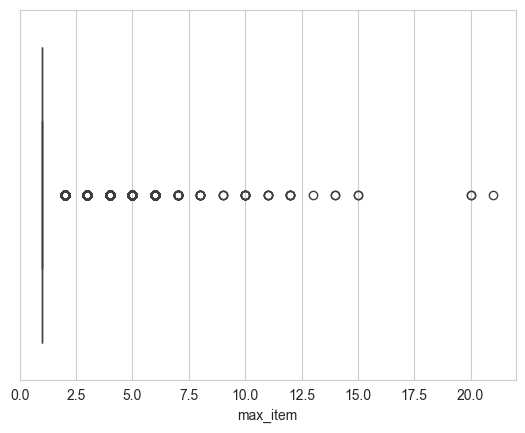

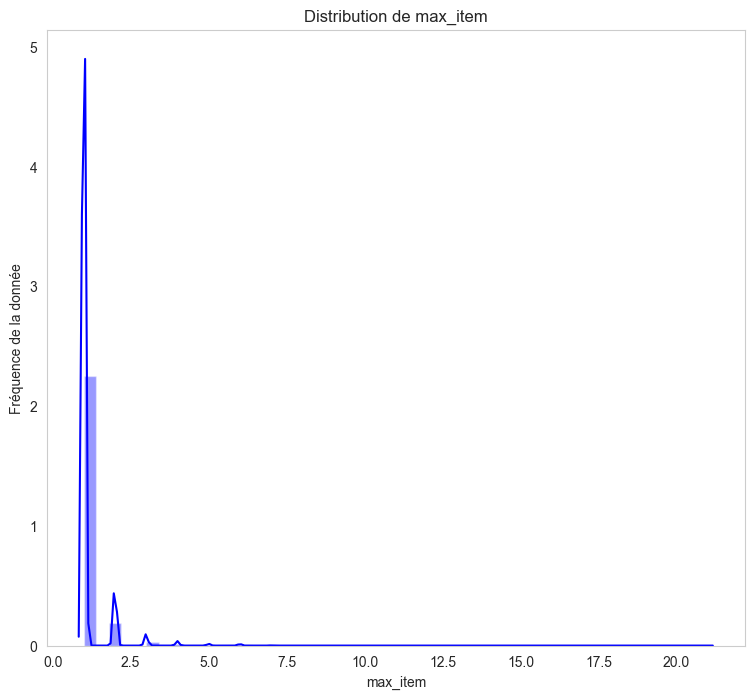

In [36]:
describe_data_quant(data, 'max_item')


La variable "max_item" est quasiment toujours égale à 1 et n'aura donc pas beaucoup d'utilité pour le clustering.

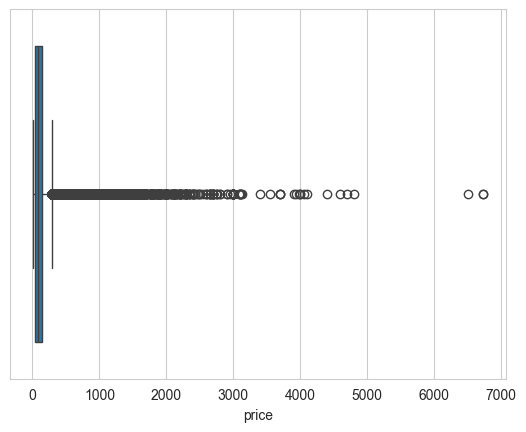

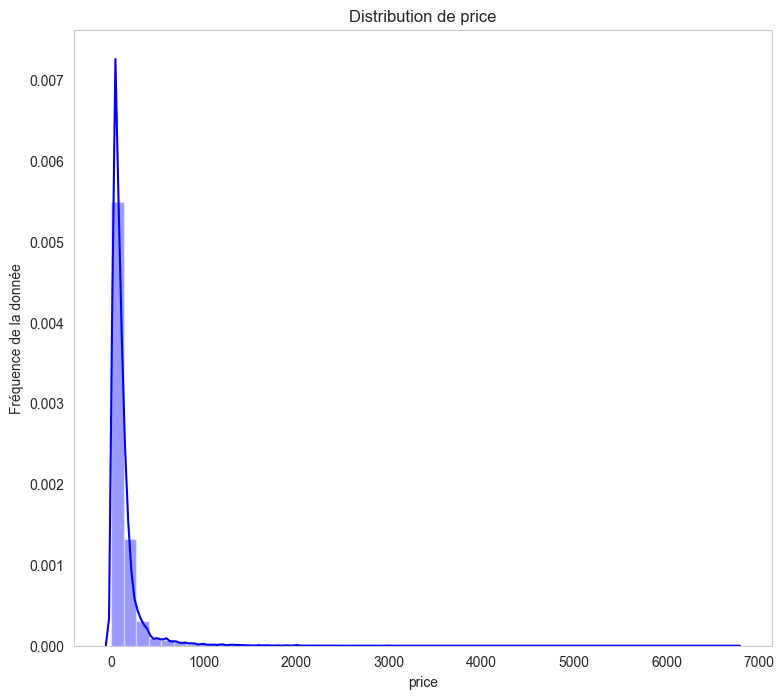

In [37]:
describe_data_quant(data, 'price')


La variable "price" a plus de variance et pourrait donc être utilisée pour le clustering.

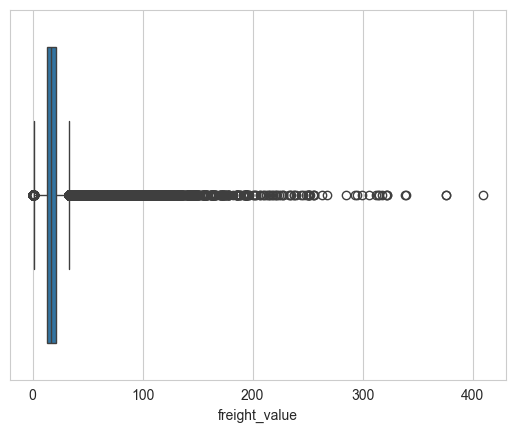

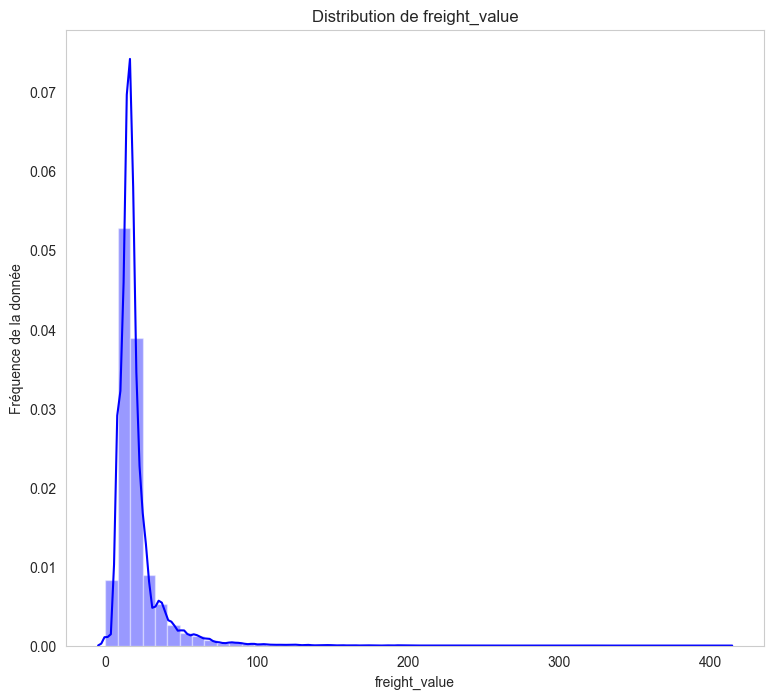

In [38]:
describe_data_quant(data, 'freight_value')


La variable "freight_value" a plus de variance et pourrait donc être utilisée pour le clustering.


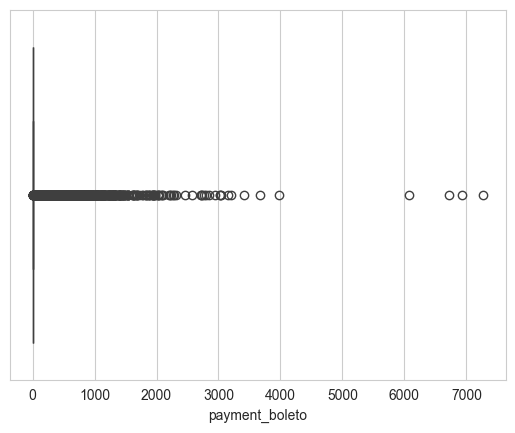

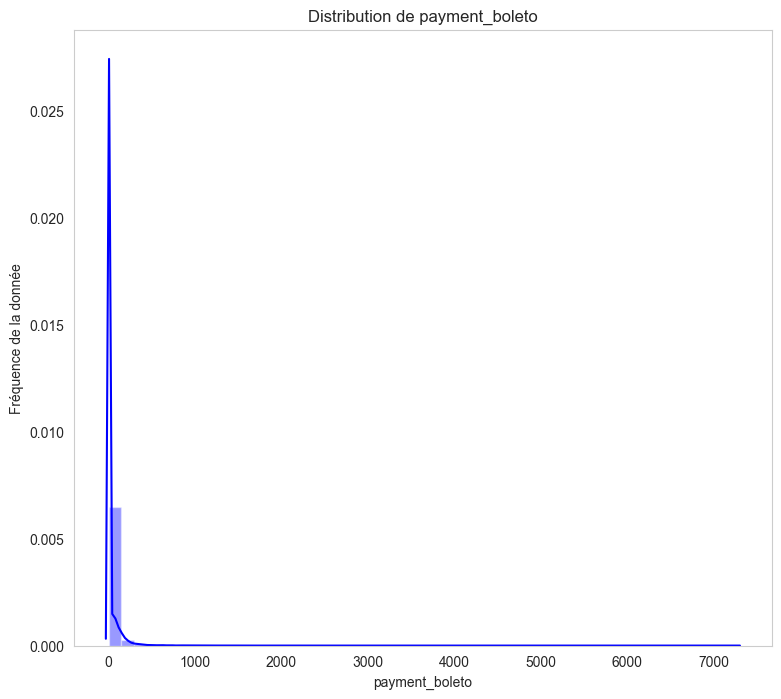

In [39]:
describe_data_quant(data, 'payment_boleto')

La variable "payment_boleto" est quasiment toujours égale à 0 et n'aura donc pas beaucoup d'utilité pour le clustering.

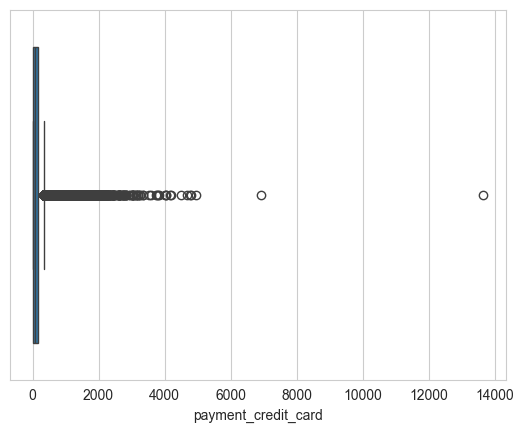

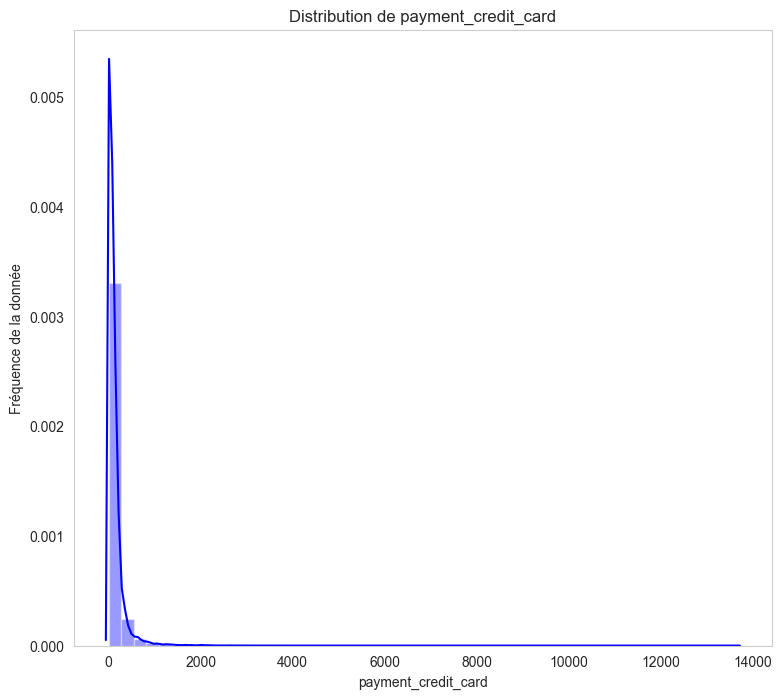

In [40]:
 describe_data_quant(data, 'payment_credit_card')

La variable "payment_credit_card" a plus de variance et pourrait donc être utilisée pour le clustering.

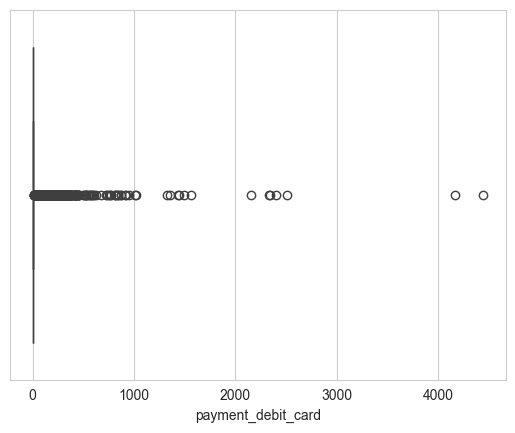

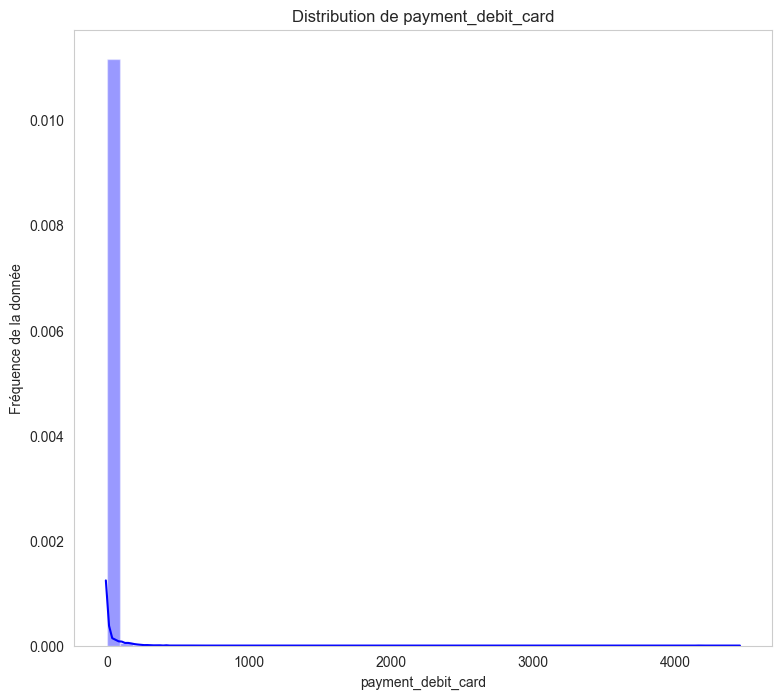

In [41]:
 describe_data_quant(data, 'payment_debit_card')

La variable "payment_debit_card" est quasiment toujours égale à 0 et n'aura donc pas beaucoup d'utilité pour le clustering.

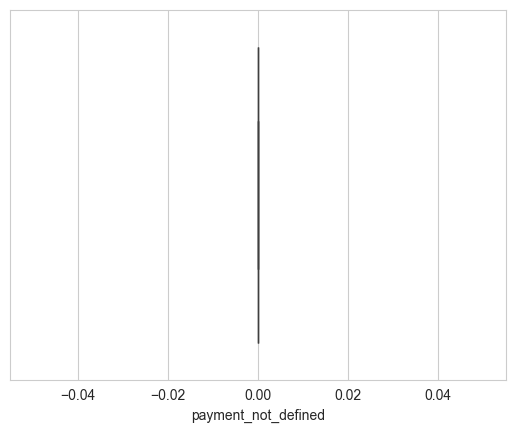

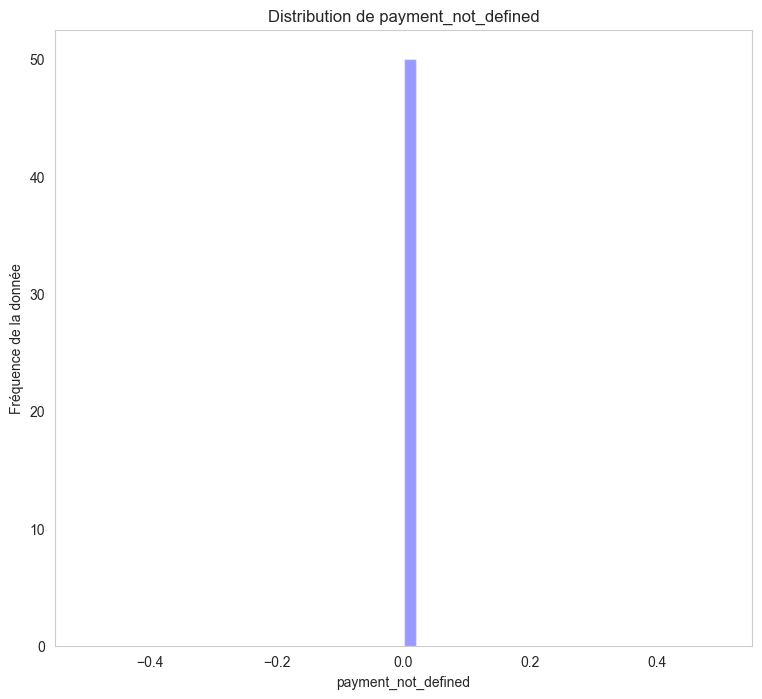

In [42]:
 describe_data_quant(data, 'payment_not_defined')

La variable "payment_not_defined" est toujours égale à 0 et n'aura donc pas beaucoup d'utilité pour le clustering.

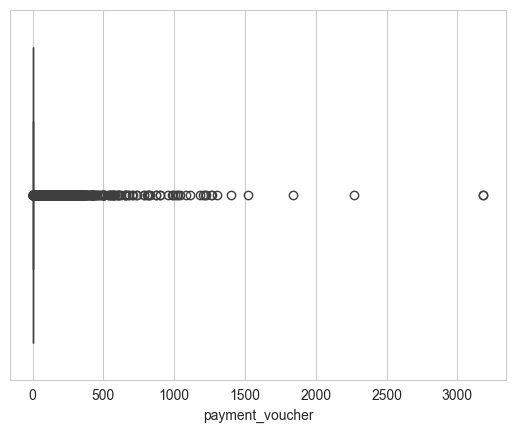

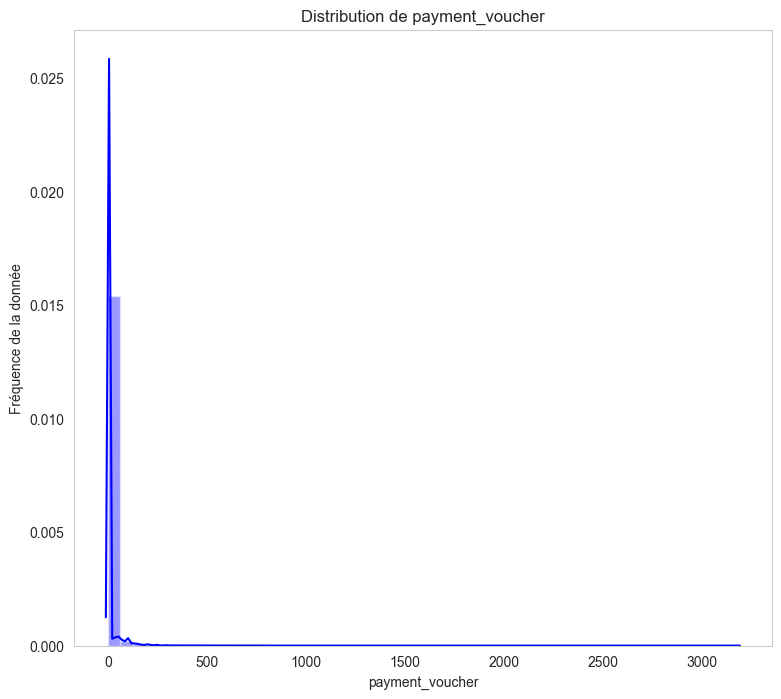

In [43]:
 describe_data_quant(data, 'payment_voucher')

La variable "payment_voucher" est quasiment toujours égale à 0 et n'aura donc pas beaucoup d'utilité pour le clustering.

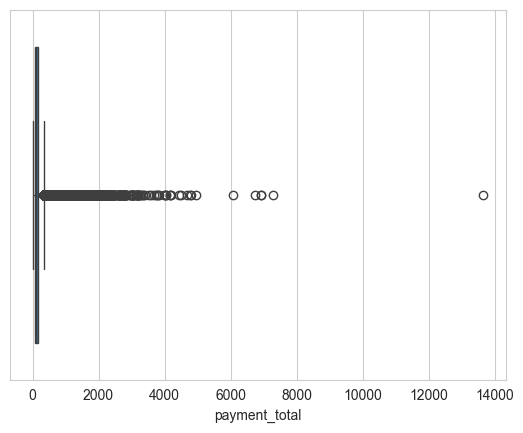

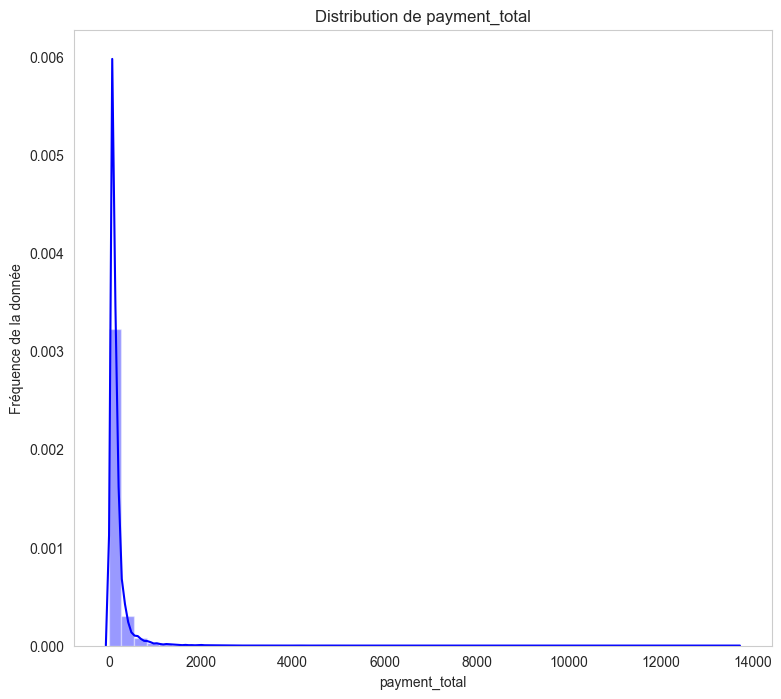

In [44]:
   describe_data_quant(data, 'payment_total')


La variable "payment_total" a plus de variance et pourrait donc être utilisée pour le clustering.

Les prix totaux sont globalement peu élevés.

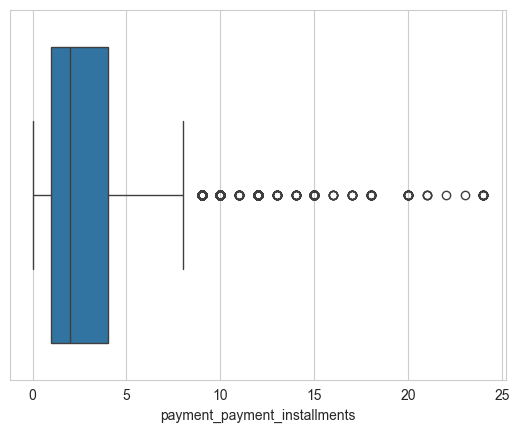

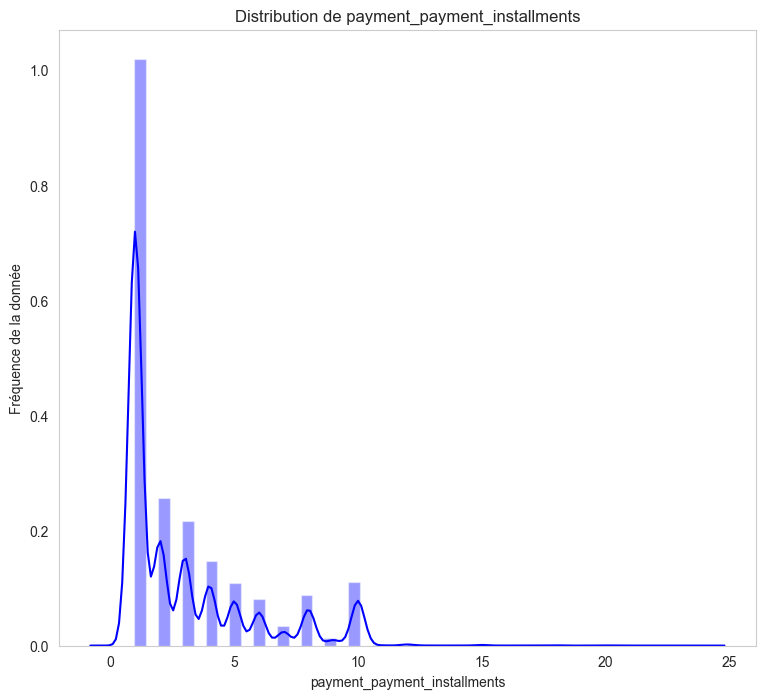

In [45]:
   describe_data_quant(data, 'payment_payment_installments')

La variable "payment_payment_installments" a plus de variance et pourrait donc être utilisée pour le clustering.

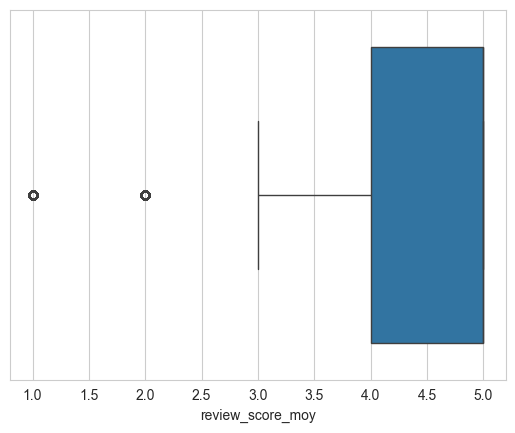

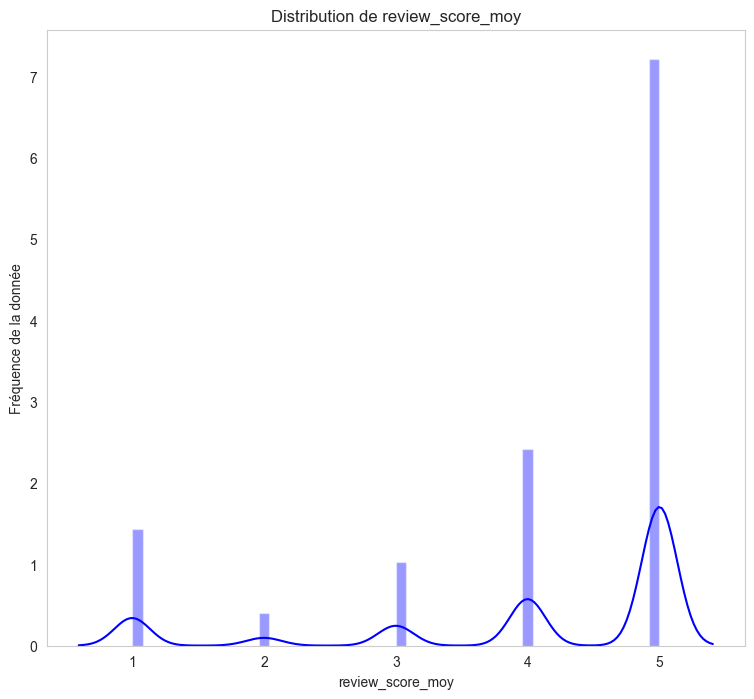

In [46]:
   describe_data_quant(data, 'review_score_moy')

La variable "review_score_moy" a plus de variance et pourrait donc être utilisée pour le clustering.

Les notes clients sont globalement très bonnes.

### Variables qualitatives:

In [47]:
def describe_data_qual(data, col):
    # filtering non-null data for the feature
    mask = data[col].notnull()
    df = data[mask]

    # Setting the data to plot
    x=df[col]

    # Set frequencies and labels, sorting by index
    labels = list(x.value_counts().sort_values(ascending=False).index.astype(str))
    frequencies = x.value_counts().sort_values(ascending=False)

    # Graphical properties of the main figure
    fig = plt.figure(figsize=(18, 6))

    plt.suptitle("Distribution de : " + col, fontsize=25)

    # Main graphical properties of the first subplot (histogram)
    ax1 = plt.subplot(121)
    ax1.set_xlabel(col, fontsize=20)
    ax1.set_ylabel("Frequences", fontsize=20)
    ax1.set_xticklabels(labels, rotation=45, horizontalalignment="right")

    # Main graphical properties of the second subplot (pieplot)
    ax2 = plt.subplot(122)
    ax2.set_xlabel("Frequences en %", fontsize=20)

    # plotting the plots
    ax1.bar(labels, frequencies)
    ax2.pie(frequencies,
            autopct='%1.2f%%',
            shadow=True,
              )

    ax2.legend(labels)

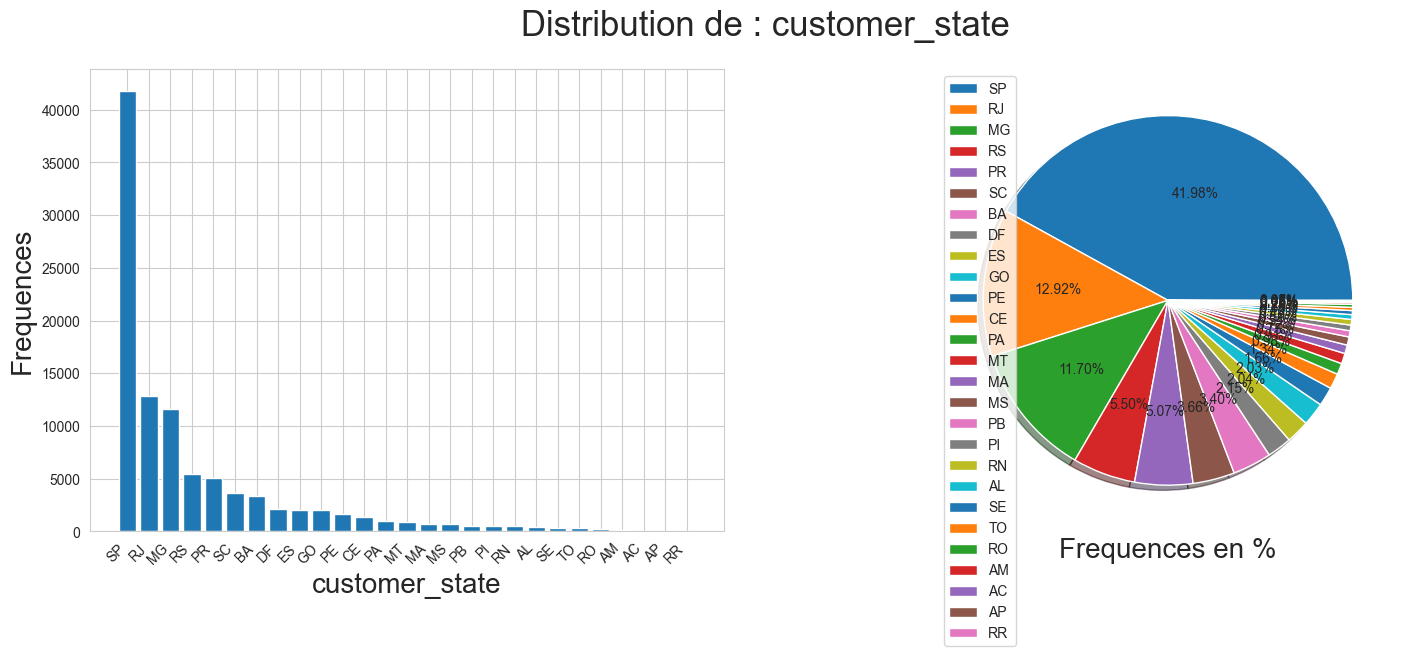

In [48]:
describe_data_qual(data, 'customer_state')


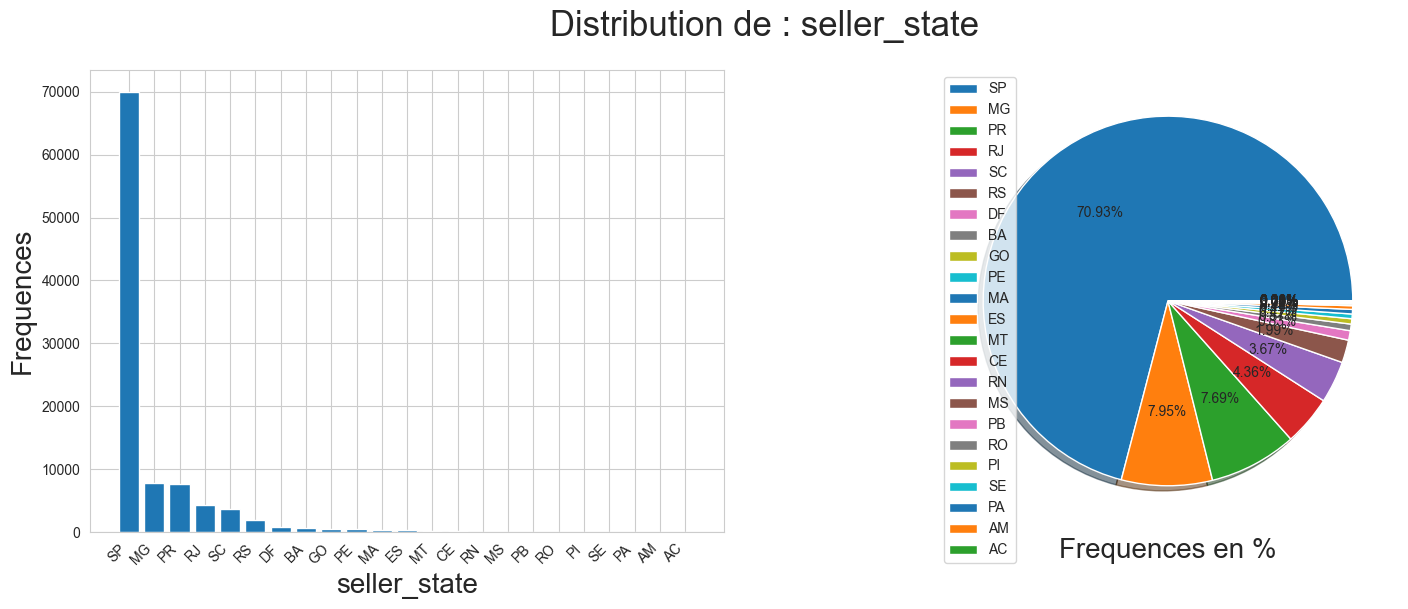

In [49]:
describe_data_qual(data, 'seller_state')


2024-09-27 11:31:15 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-27 11:31:15 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


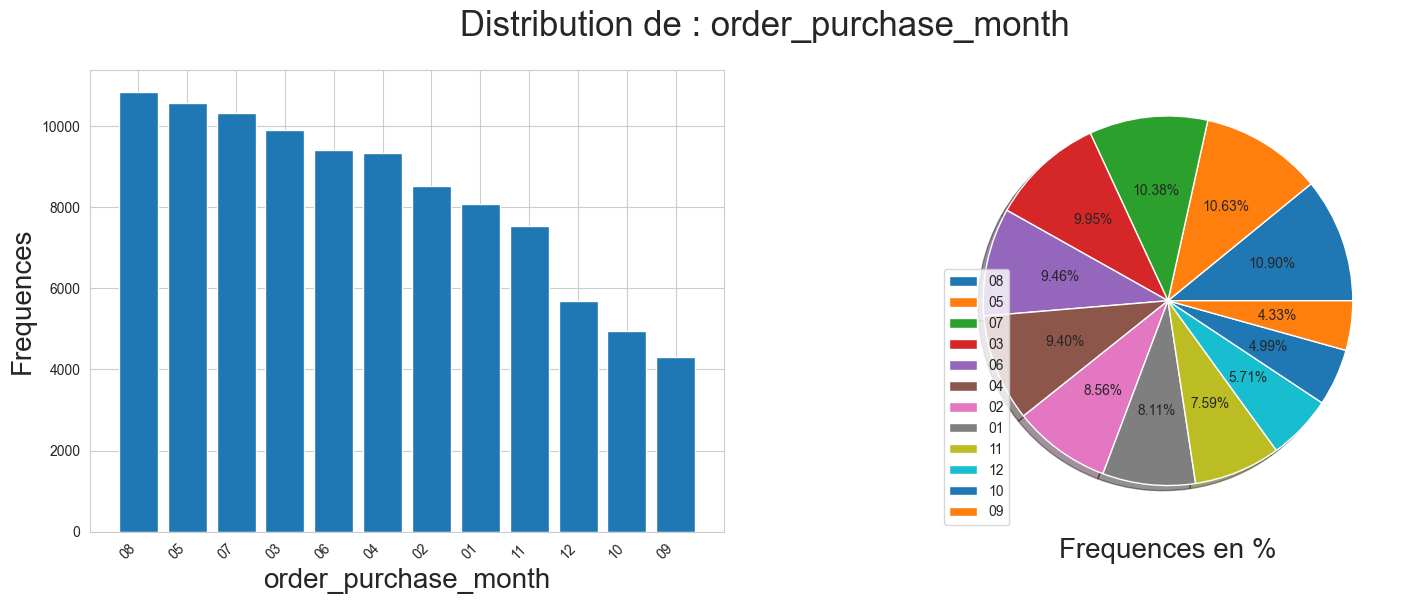

In [50]:
describe_data_qual(data, 'order_purchase_month')

2024-09-27 11:31:16 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-27 11:31:16 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


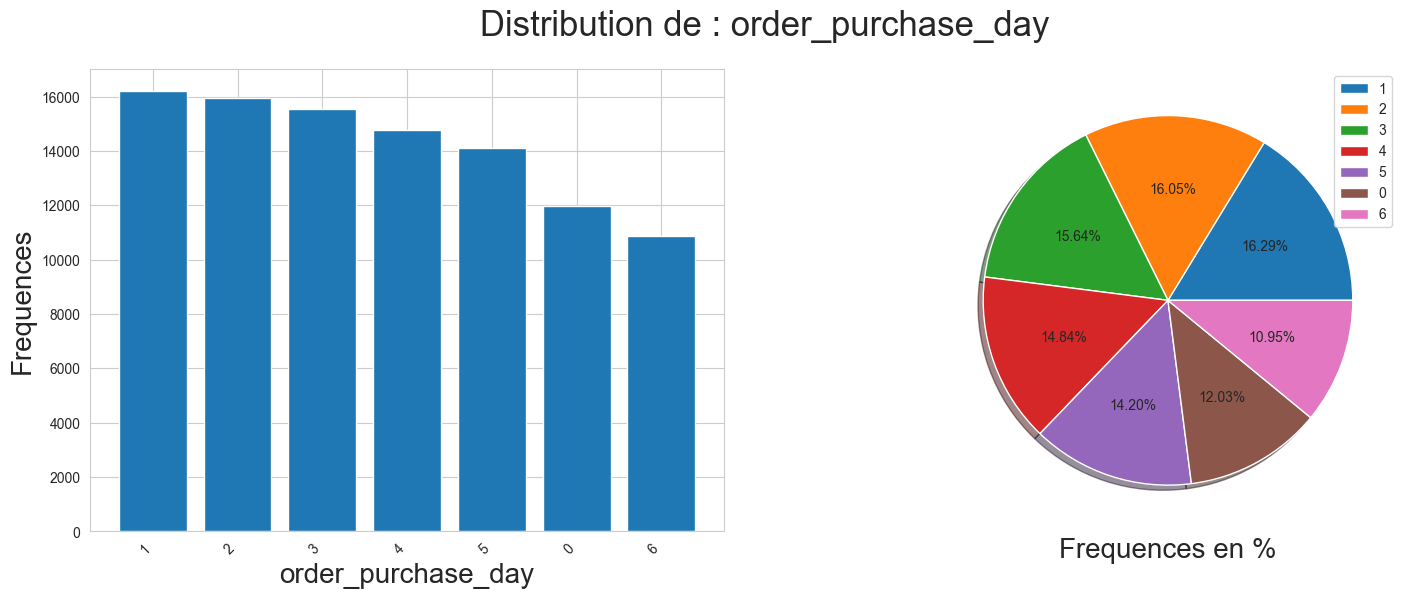

In [51]:
describe_data_qual(data, 'order_purchase_day') #day of week 0-6 with Sunday==0


2024-09-27 11:31:18 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-27 11:31:18 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


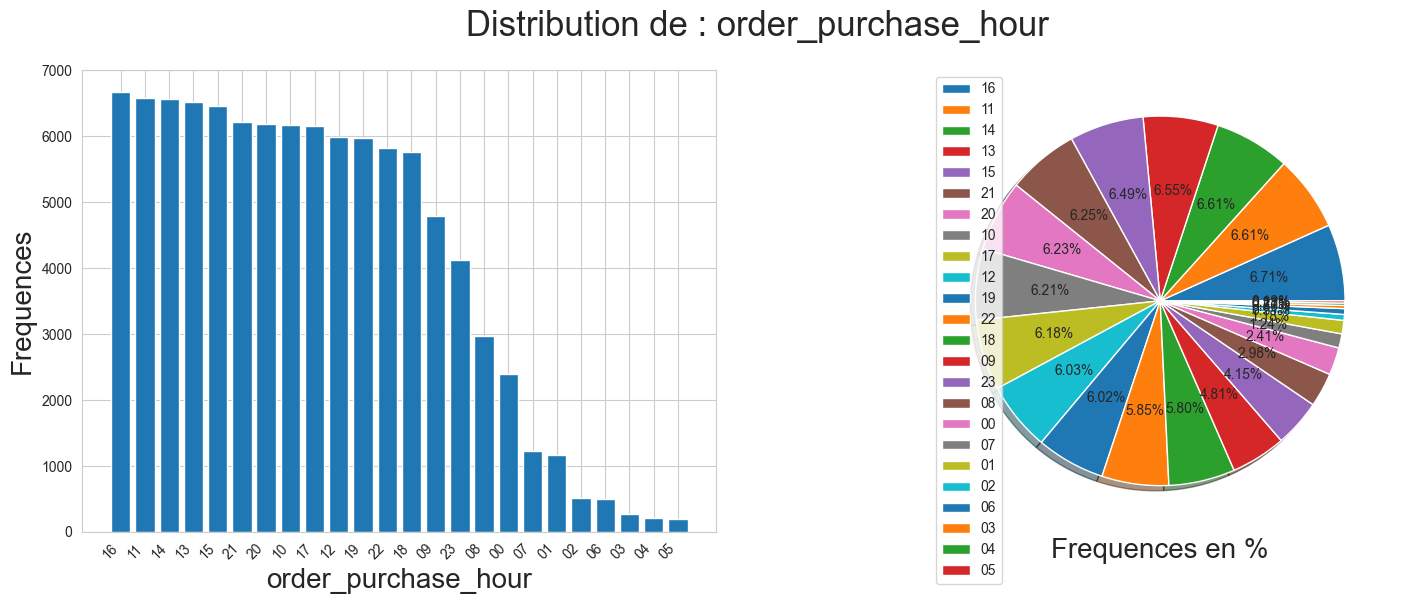

In [52]:
describe_data_qual(data, 'order_purchase_hour')

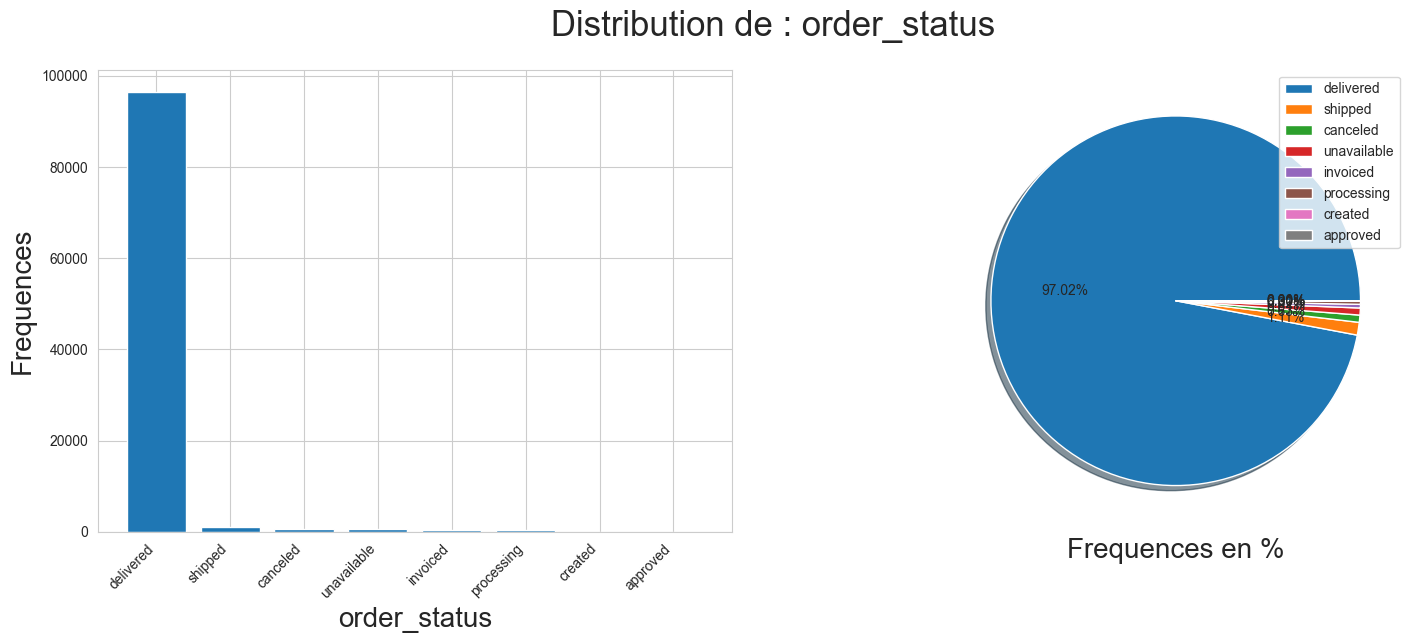

In [53]:
describe_data_qual(data, 'order_status')

Les autres variables catégorielles ont trop de catégories pour qu'elles soient pertinentes.

## Analyse multivariée:

### Corrélations:

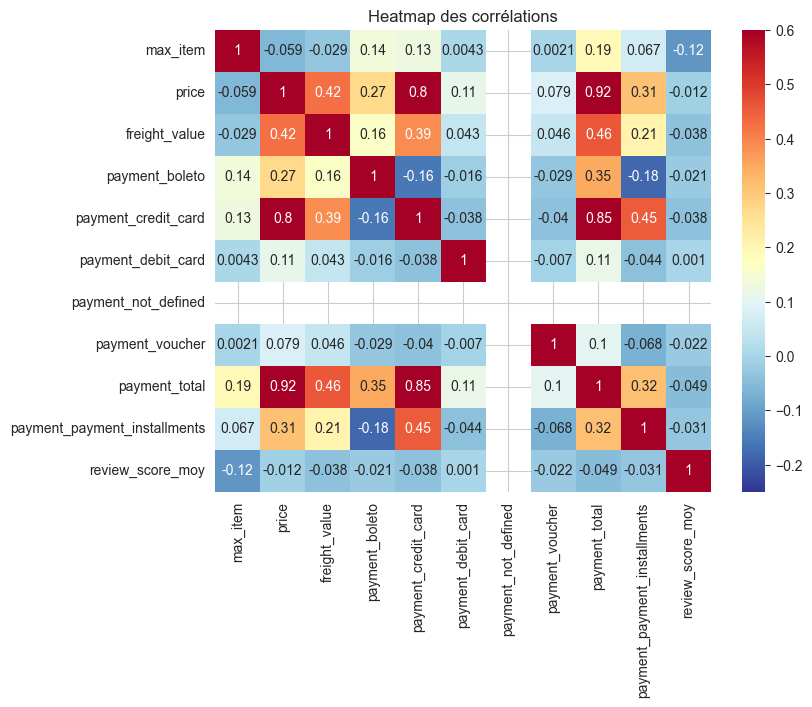

In [54]:
plt.figure(figsize = (8, 6))
data_corr = data.select_dtypes(include=['float', 'int32'])
# Heatmap des correlations
sns.heatmap(data_corr.corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Heatmap des corrélations');

Les différents type de paiement ne seront pas gardés car ils n'ont soit pas assez de variance , soit sont corrélés avec le prix.

### Nombre de commandes selon les jours et heures:

2024-09-27 11:31:23 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-27 11:31:24 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='order_purchase_hour', ylabel='count'>

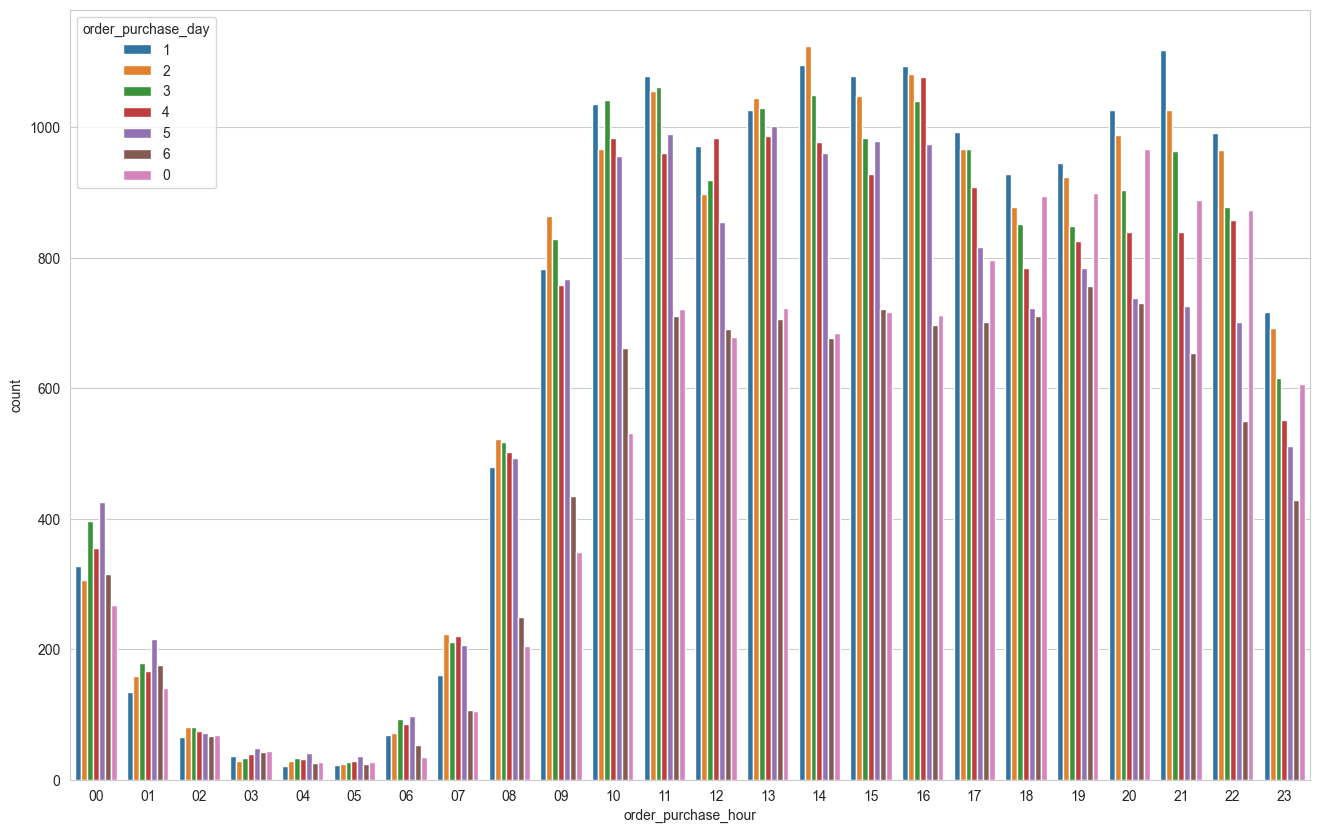

In [55]:
plt.figure(figsize = (16, 10))

sns.countplot(data, x="order_purchase_hour",hue="order_purchase_day",order=['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23'], hue_order=['1','2','3','4','5','6','0'])


Nous pouvons voir une baisse de commande entre minuit et 7h du matin dans le comportement des utilisateurs.

De même, le week-end (jour 6 = samedi / jour 0 = dimanche) n'est pas la période où les utilisateurs commande le plus.

Le dimanche soir à partir de 18h, les commandes deviennent plus proches de celles effectuées en semaine dans ces mêmes heures.

### Nombre de commandes selon les jours et mois:

2024-09-27 11:31:26 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-27 11:31:26 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='order_purchase_month', ylabel='count'>

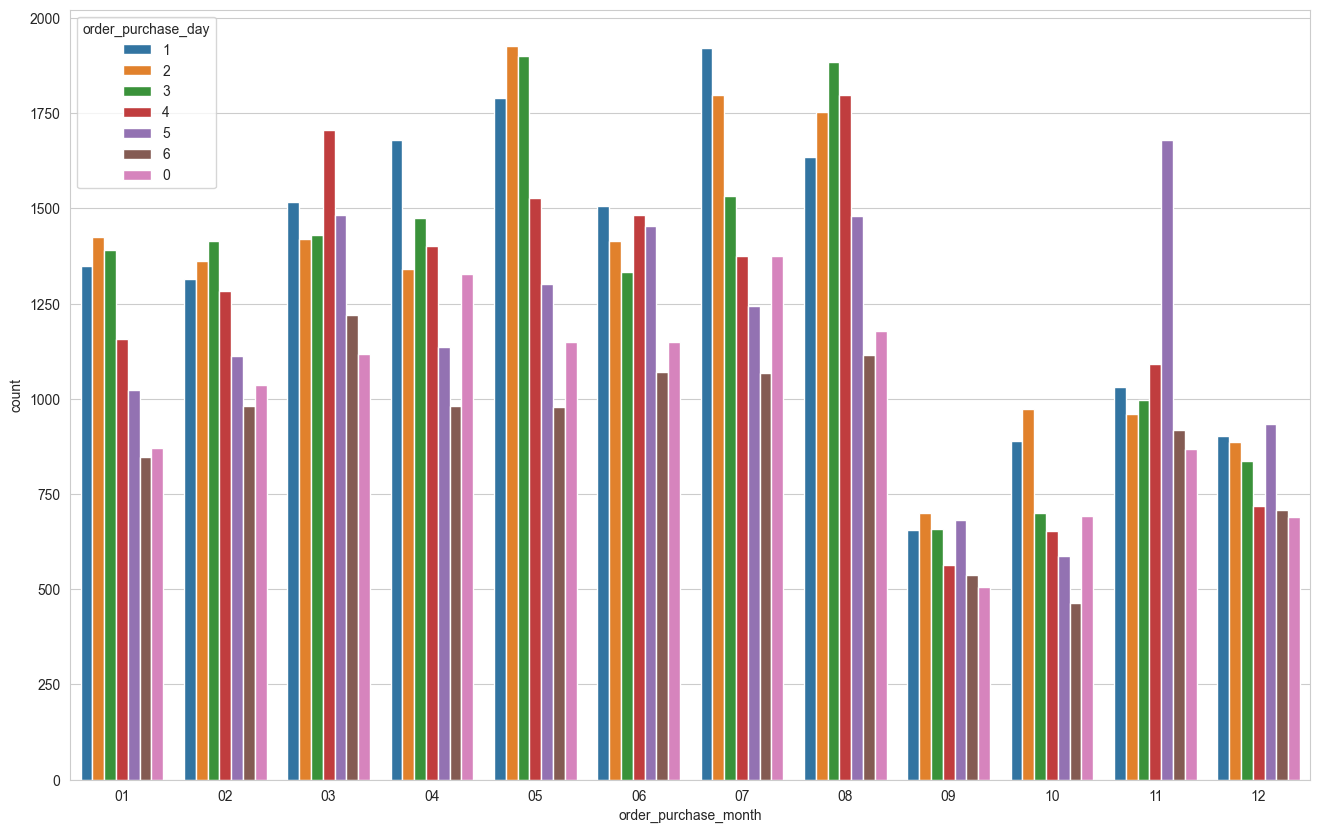

In [56]:
plt.figure(figsize = (16, 10))

sns.countplot(data, x="order_purchase_month",hue="order_purchase_day",order=['01','02','03','04','05','06','07','08','09','10','11','12'], hue_order=['1','2','3','4','5','6','0'])


Nous pouvons voir une baisse de commande en fin d'année, globalement de septembre à décembre, dans le comportement des utilisateurs.

On note toujours que le week-end (jour 6 = samedi / jour 0 = dimanche) n'est pas la période où les utilisateurs commande le plus.

Pour la période novembre-décembre, c'est le samedi que les commandes sont les plus importantes contrairement aux autres mois de l'année. C'est peut-être la période de Noël qui change le comportement des clients.


### Prix des commandes en fonction du mois, du jour ou de l'heure:

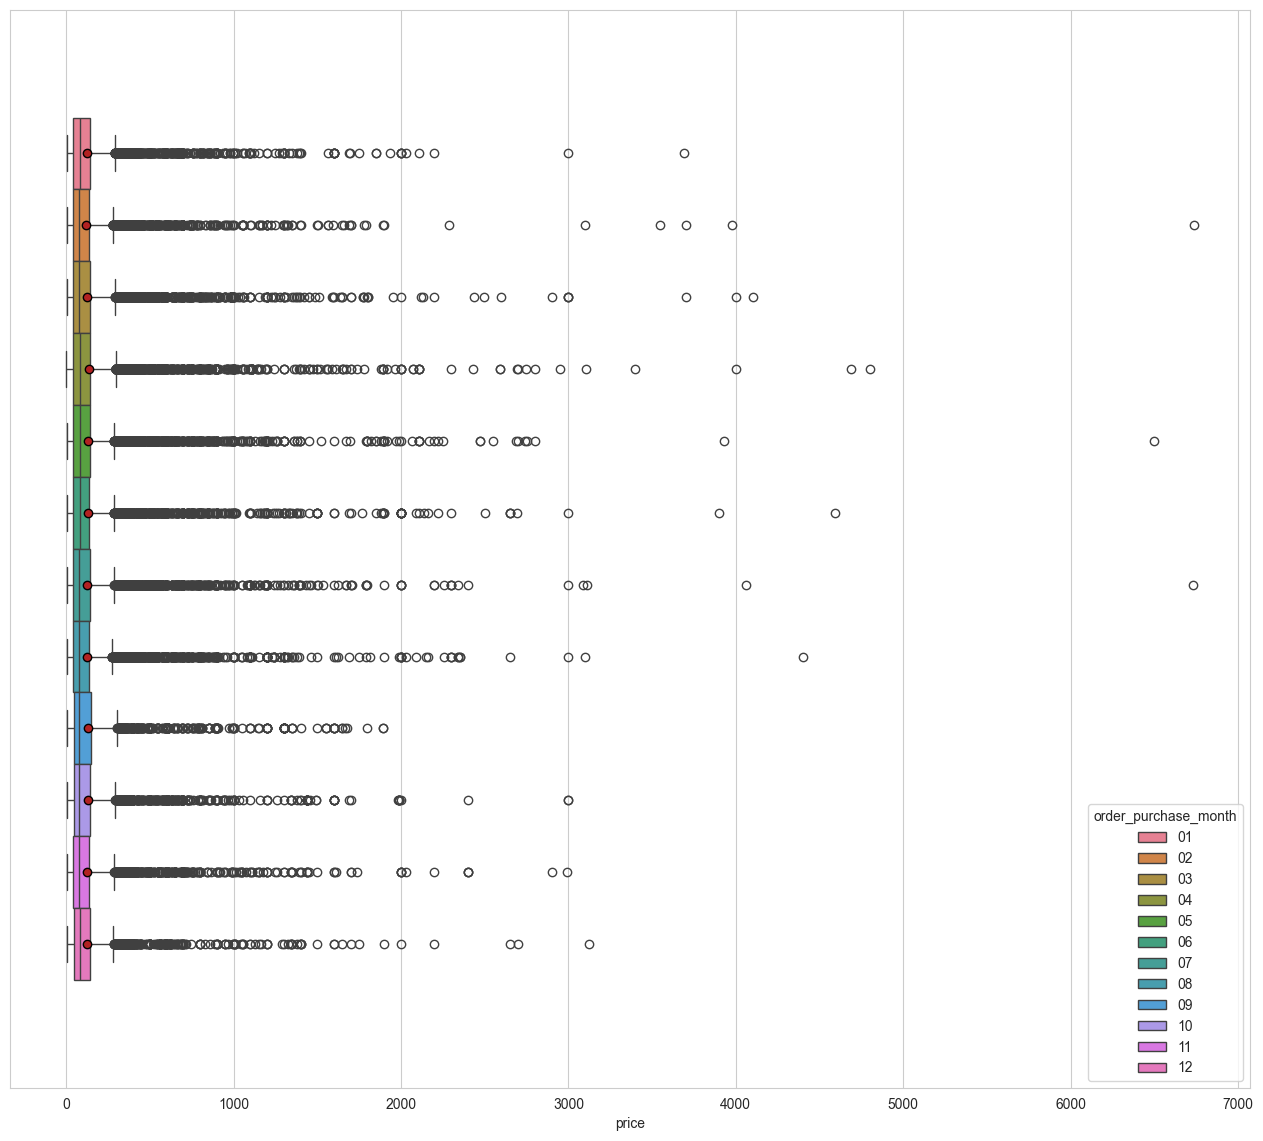

In [57]:
plt.figure(figsize = (16, 14))
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}
sns.boxplot(data=data,x="price", hue="order_purchase_month", showmeans=True, meanprops=meanprops, hue_order=['01','02','03','04','05','06','07','08','09','10','11','12'])
plt.show()

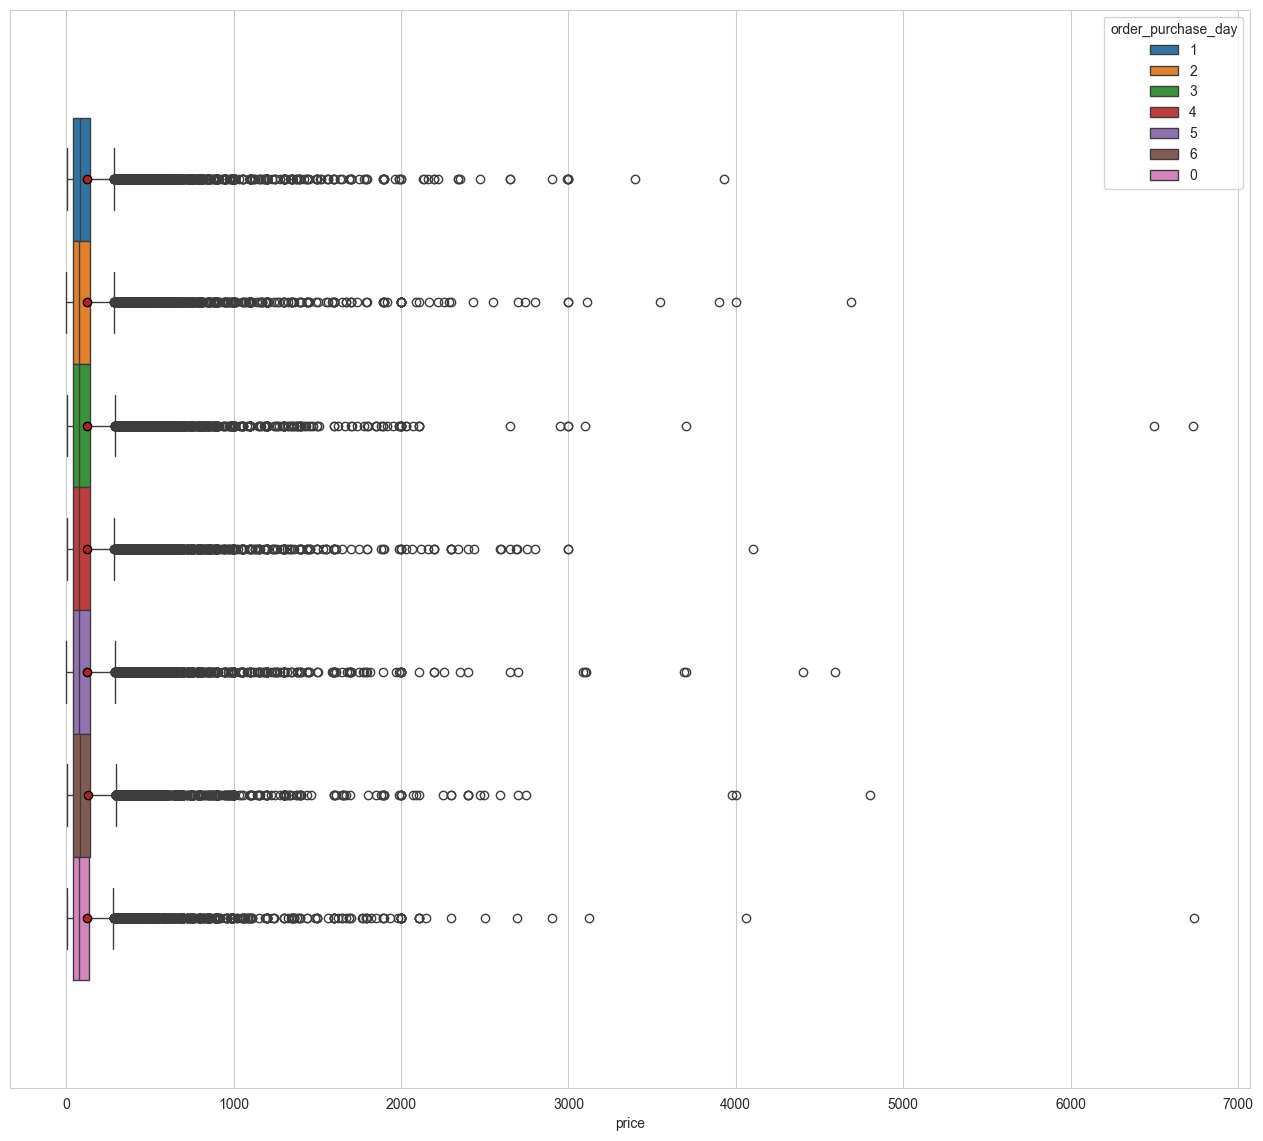

In [58]:
plt.figure(figsize = (16, 14))
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}
sns.boxplot(data=data,x="price", hue="order_purchase_day", showmeans=True, meanprops=meanprops, hue_order=['1','2','3','4','5','6','0'])
plt.show()

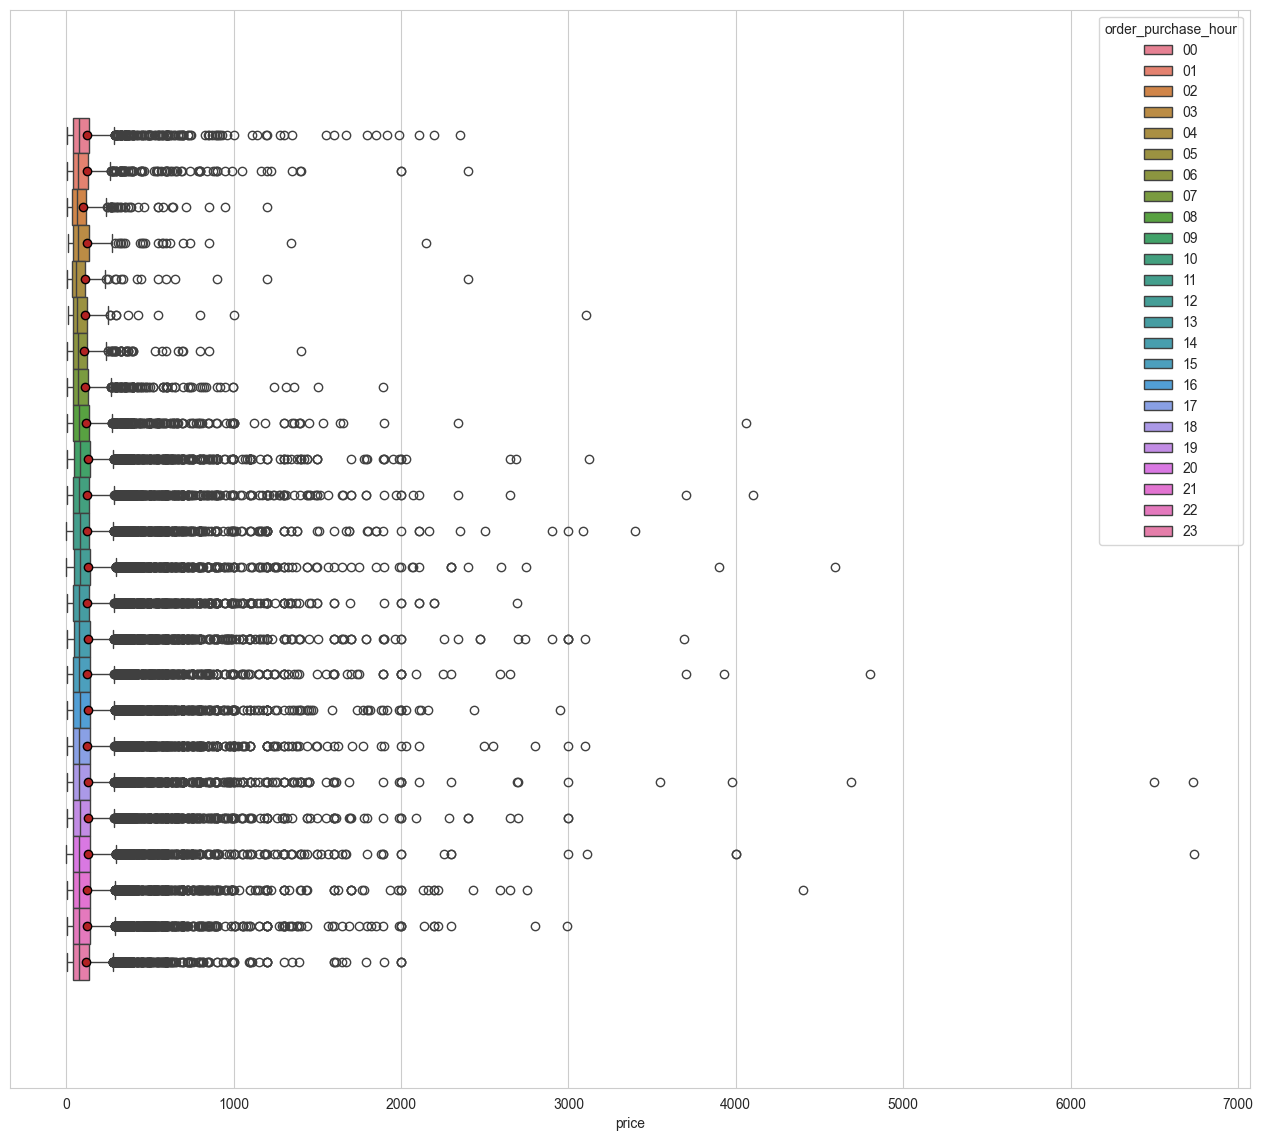

In [59]:
plt.figure(figsize = (16, 14))
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}
sns.boxplot(data=data,x="price", hue="order_purchase_hour", showmeans=True, meanprops=meanprops, hue_order=['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23'])
plt.show()

Nous pouvons remarquer que les commandes ont toutes des prix peu élevées peu importe le mois, le jour ou l'heure en moyenne.

Les achats les plus coûteux sont fait le mercredi ou le dimanche, plutôt en soirée (18-20h).

### Variables quantitatives avec variance pertinente:

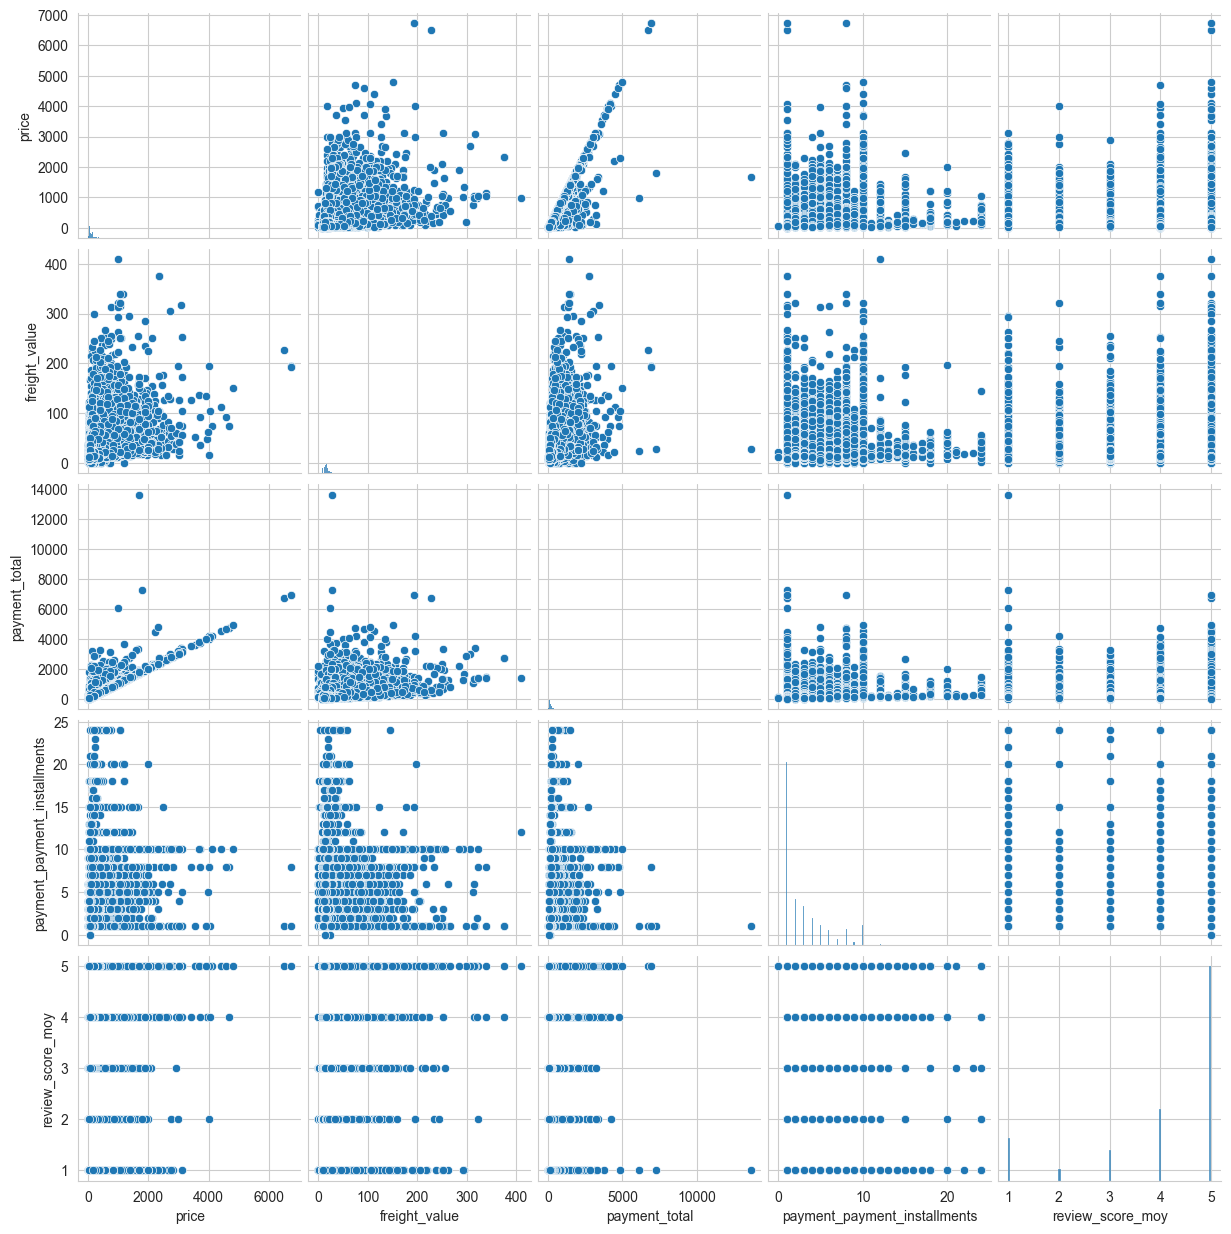

In [60]:
sns.pairplot(data[['price',	'freight_value',	'payment_total',	'payment_payment_installments',	'review_score_moy']])

Nous pouvons remarquer que :
- le paiement total et le prix évoluent globalement de la même façon pour un certain nombre de commandes, on imagine donc que pour ces commandes les frais de port sont nuls ou très peu élevés.
- on distingue que les frais de port n'augmente pas en fonction du prix de la commande.
-étrangement, ce n'est pas sur les commandes les plus coûteuses qu'il y a le plus de versements.
- de façon globale, les notes clients sont élevés, notamment pour les commandes coûteuses.

## Feature Engineering:

Création de colonnes avec des délais pour s'affranchir des dates qui ne sont pas pris en compte pour les algorithmes :    
- délai entre la commande et l'estimation de livraison : "estimated_delivery_delay"
- délai entre la commande et la date de livraison : "true_delivery_delay"
- retard de livraison (ou avance si négatif) par rapport à la date de livraison estimée : "late_delivery"

On ne gardera que les variables pertinentes pour le clustering.

In [61]:
data_order=pd.read_csv('D:/tutorial-env/OCR/Projet5/data_order.csv')

pd_to_sqlDB(data_order,
            table_name='order_data_CL',
            db_name='/tutorial-env/OCR/Projet5/olist.db')

sql_query_string = """
SELECT customer_unique_id,customer_state,order_id,order_status,order_purchase_date,order_purchase_month,order_purchase_day,order_purchase_hour ,(JulianDay(order_estimated_delivery_date) - JulianDay(order_purchase_date)) AS estimated_delivery_delay,(JulianDay(order_delivered_customer_date) - JulianDay(order_purchase_date)) AS true_delivery_delay,(JulianDay(order_delivered_customer_date) - JulianDay(order_estimated_delivery_date)) AS late_delivery,price,freight_value,payment_total,payment_payment_installments,review_score_moy,seller_id,seller_state
FROM order_data_CL
ORDER BY 1
"""

df_temp=sql_query_to_pd(sql_query_string, db_name='/tutorial-env/OCR/Projet5/olist.db')

2024-09-27 11:32:16 INFO: SQL DB /tutorial-env/OCR/Projet5/olist.db created
2024-09-27 11:32:16 INFO: SQL Table order_data_CL created with 29 columns
2024-09-27 11:32:20 INFO: 99441 rows uploaded to order_data_CL


In [62]:
# Création du dataframe data_fe :
data_fe = pd.DataFrame(df_temp)
data_fe

customer_unique_id customer_state  \
0      0000366f3b9a7992bf8c76cfdf3221e2             SP   
1      0000b849f77a49e4a4ce2b2a4ca5be3f             SP   
2      0000f46a3911fa3c0805444483337064             SC   
3      0000f6ccb0745a6a4b88665a16c9f078             PA   
4      0004aac84e0df4da2b147fca70cf8255             SP   
...                                 ...            ...   
99436  fffcf5a5ff07b0908bd4e2dbc735a684             PE   
99437  fffea47cd6d3cc0a88bd621562a9d061             BA   
99438  ffff371b4d645b6ecea244b27531430a             MT   
99439  ffff5962728ec6157033ef9805bacc48             ES   
99440  ffffd2657e2aad2907e67c3e9daecbeb             PR   

                               order_id order_status order_purchase_date  \
0      e22acc9c116caa3f2b7121bbb380d08e    delivered          2018-05-10   
1      3594e05a005ac4d06a72673270ef9ec9    delivered          2018-05-07   
2      b33ec3b699337181488304f362a6b734    delivered          2017-03-10   
3      41272756ecddd9a9ed0180413cc22fb6    delivered          2017-10-12   
4      d957021f1127559cd947b62533f484f7    delivered          2017-11-14   
...                                 ...          ...                 ...   
99436  725cf8e9c24e679a8a5a32cb92c9ce1e    delivered          2017-06-08   
99437  c71b9252fd7b3b263aaa4cb09319a323    delivered          2017-12-10   
99438  fdc45e6c7555e6cb3cc0daca2557dbe1    delivered          2017-02-07   
99439  94d3ee0bc2a0af9d4fa47a4d63616e8d    delivered          2018-05-02   
99440  f79a35da168301ae56922475da21117b    delivered          2017-05-02   

       order_purchase_month  order_purchase_day  order_purchase_hour  \
0                         5                   4                   10   
1                         5                   1                   11   
2                         3                   5                   21   
3                        10                   4                   20   
4                        11                   2                   19   
...                     ...                 ...                  ...   
99436                     6                   4                   21   
99437                    12                   0                   20   
99438                     2                   2                   15   
99439                     5                   3                   15   
99440                     5                   2                   20   

       estimated_delivery_delay  true_delivery_delay  late_delivery   price  \
0                          11.0                  6.0           -5.0  129.90   
1                           8.0                  3.0           -5.0   18.90   
2                          28.0                 26.0           -2.0   69.00   
3                          32.0                 20.0          -12.0   25.99   
4                          21.0                 13.0           -8.0  180.00   
...                         ...                  ...            ...     ...   
99436                      55.0                 28.0          -27.0  680.00   
99437                      33.0                 30.0           -3.0   64.89   
99438                      45.0                 15.0          -30.0   89.90   
99439                      26.0                 12.0          -14.0  115.00   
99440                      24.0                  8.0          -16.0   56.99   

       freight_value  payment_total  payment_payment_installments  \
0              12.00         141.90                           8.0   
1               8.29          27.19                           1.0   
2              17.22          86.22                           8.0   
3              17.63          43.62                           4.0   
4              16.89         196.89                           6.0   
...              ...            ...                           ...   
99436         239.14        2067.42                          10.0   
99437          19.69          84.58          

Faisons l'analyse de ces nouvelles variables :

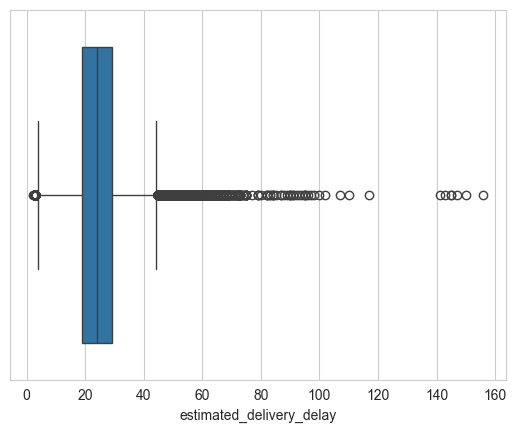

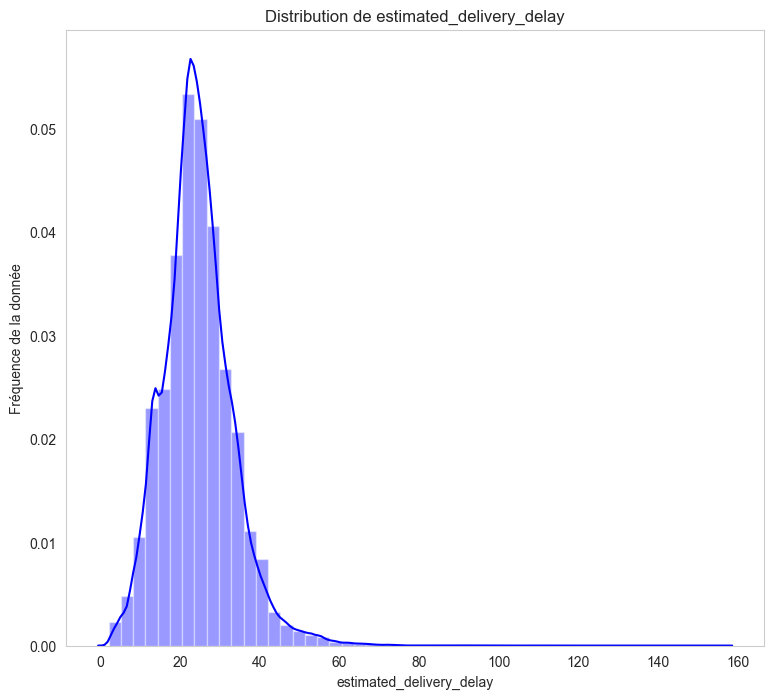

In [63]:
 describe_data_quant(data_fe, 'estimated_delivery_delay')

Les 3/4 des estimations de livraisons sont évaluées à moins d'un mois.

La variance des cette variable est assez importante pour pouvoir être utilisé dans le clustering.

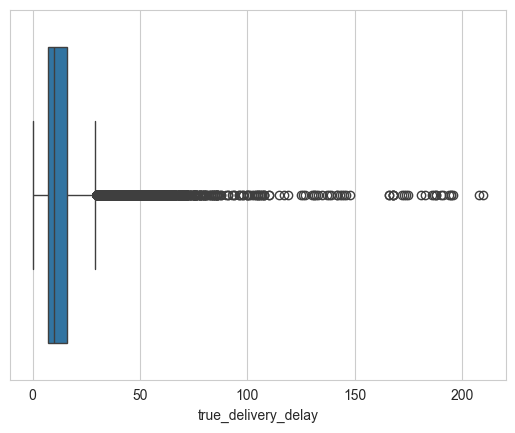

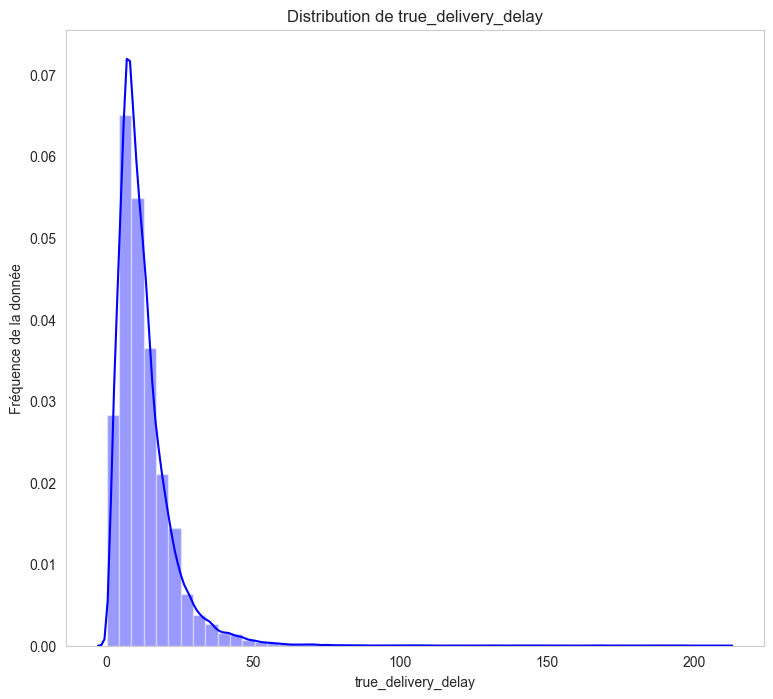

In [64]:
 describe_data_quant(data_fe, 'true_delivery_delay')

En réalité, les 3/4 des commandes sont livrées sous deux semaines.

La variance des cette variable est assez importante pour pouvoir être utilisé dans le clustering.

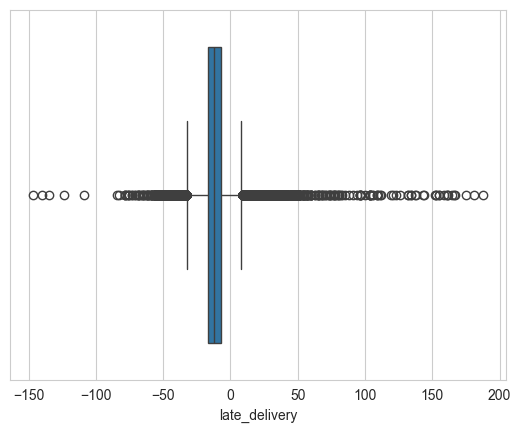

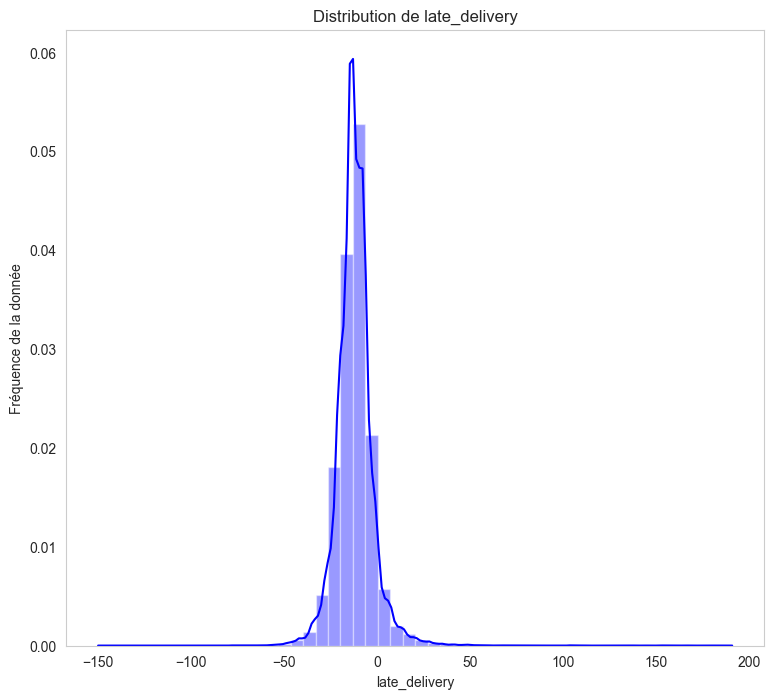

In [65]:
 describe_data_quant(data_fe, 'late_delivery')

Les 3/4 des commandes sont livrées avec au moins une semaine d'avance par rapport à la date de livraison estimée.

La variance des cette variable est assez importante pour pouvoir être utilisé dans le clustering.


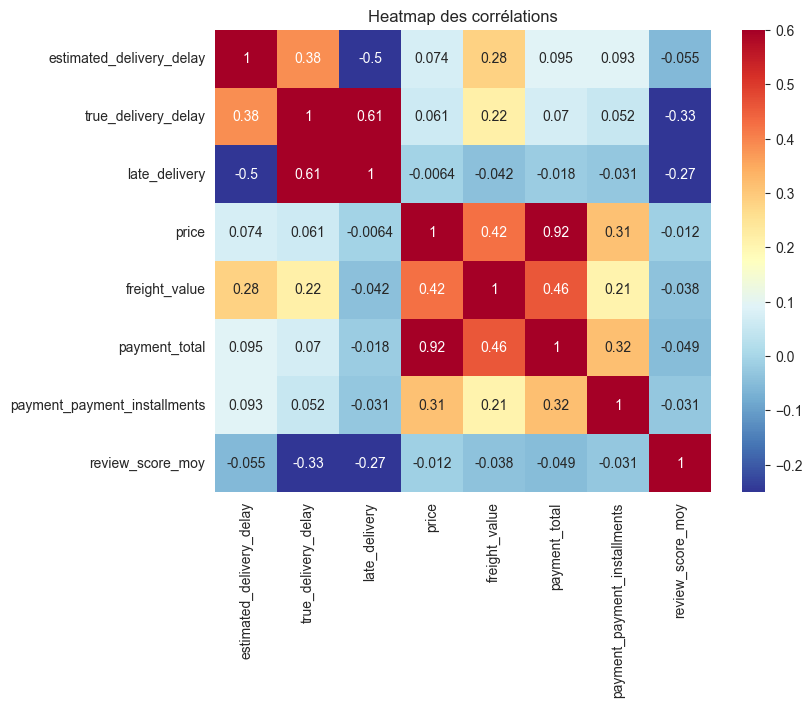

In [66]:
plt.figure(figsize = (8, 6))
data_corr = data_fe.select_dtypes(include=['float', 'int32'])
# Heatmap des correlations
sns.heatmap(data_corr.corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Heatmap des corrélations');

Nous avons toujours notre corrélation importante entre le prix et le paiement total. Nous pouvons également noter, la corrélation positive entre le délai de livraison réel et le retard/avance de livraison et la corrélation négative entre le délai de livraison estimée et le retard/avance de livraison, ce qui est assez logique.

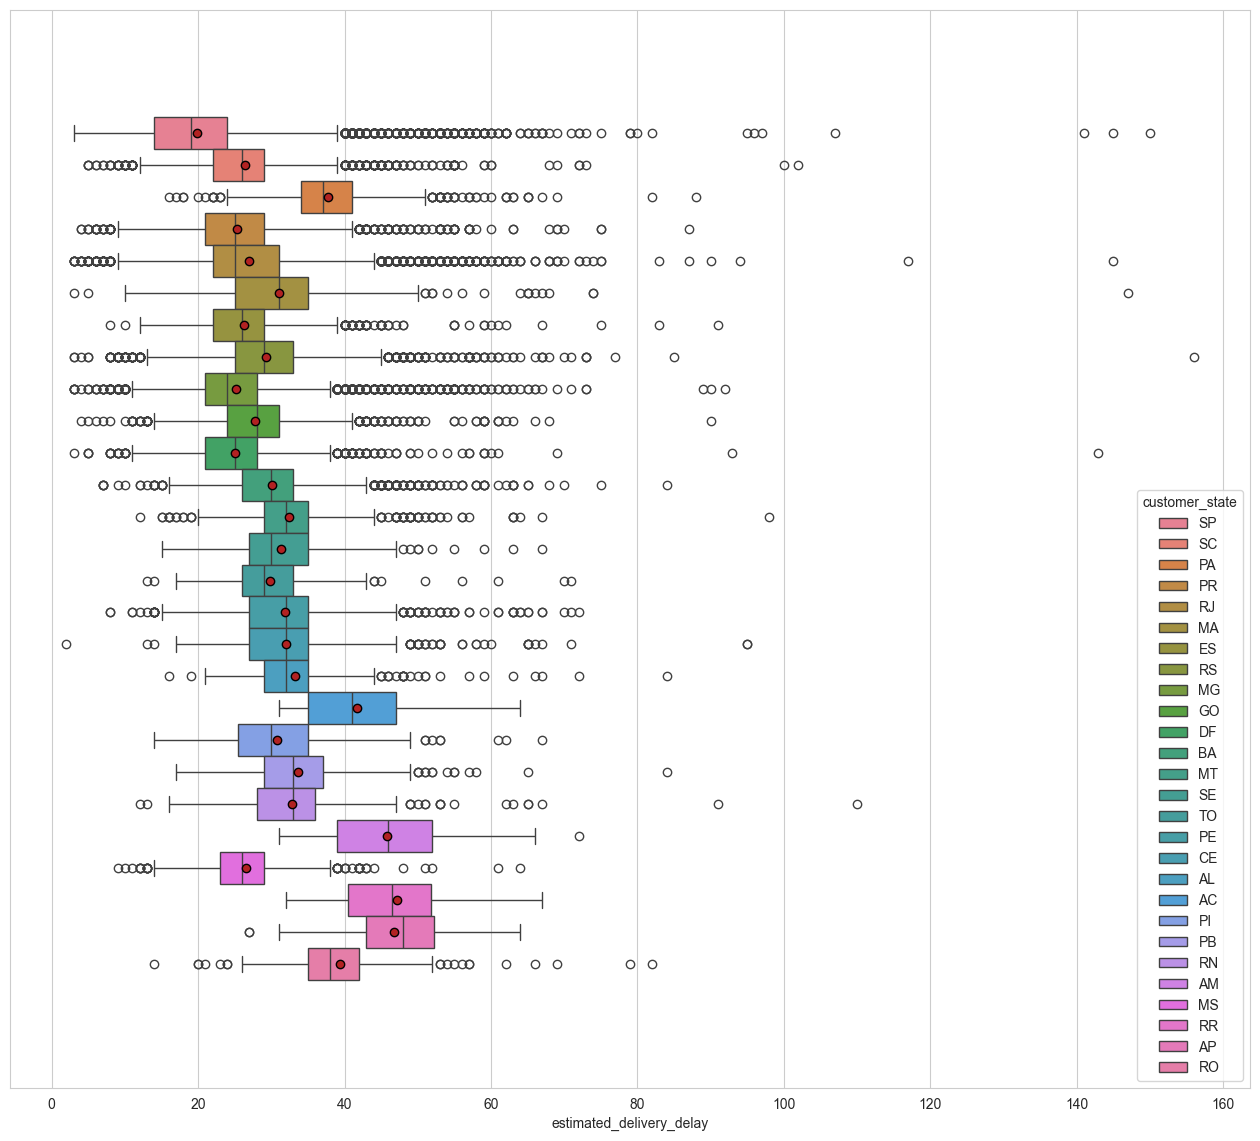

In [67]:
plt.figure(figsize = (16, 14))
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}
sns.boxplot(data=data_fe,x="estimated_delivery_delay", hue="customer_state", showmeans=True, meanprops=meanprops)
plt.show()

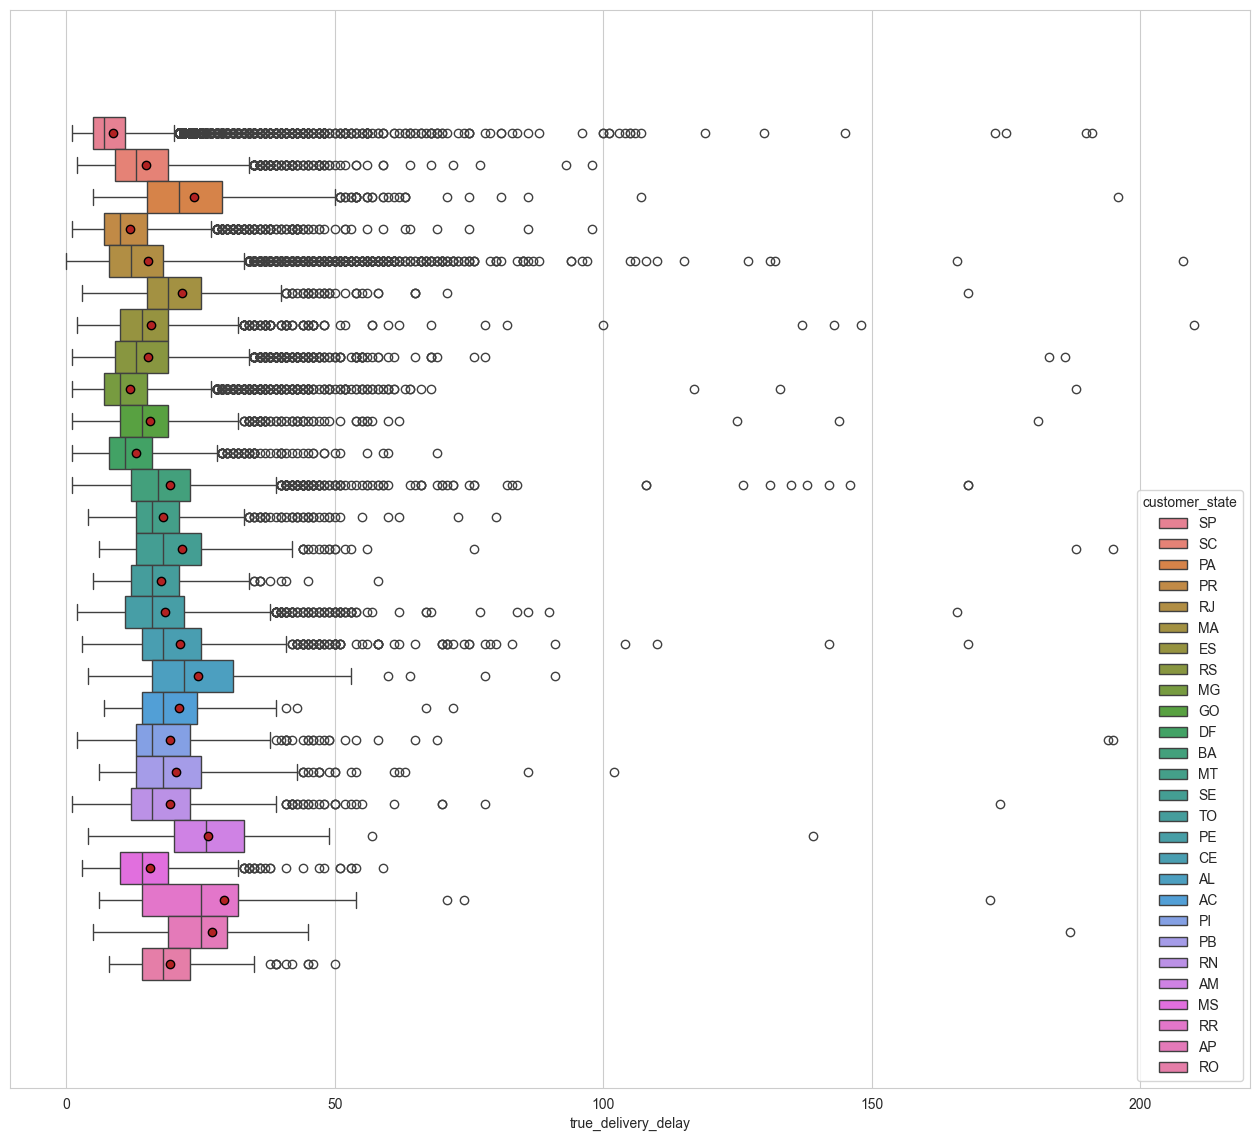

In [68]:
plt.figure(figsize = (16, 14))
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}
sns.boxplot(data=data_fe,x="true_delivery_delay", hue="customer_state", showmeans=True, meanprops=meanprops)
plt.show()

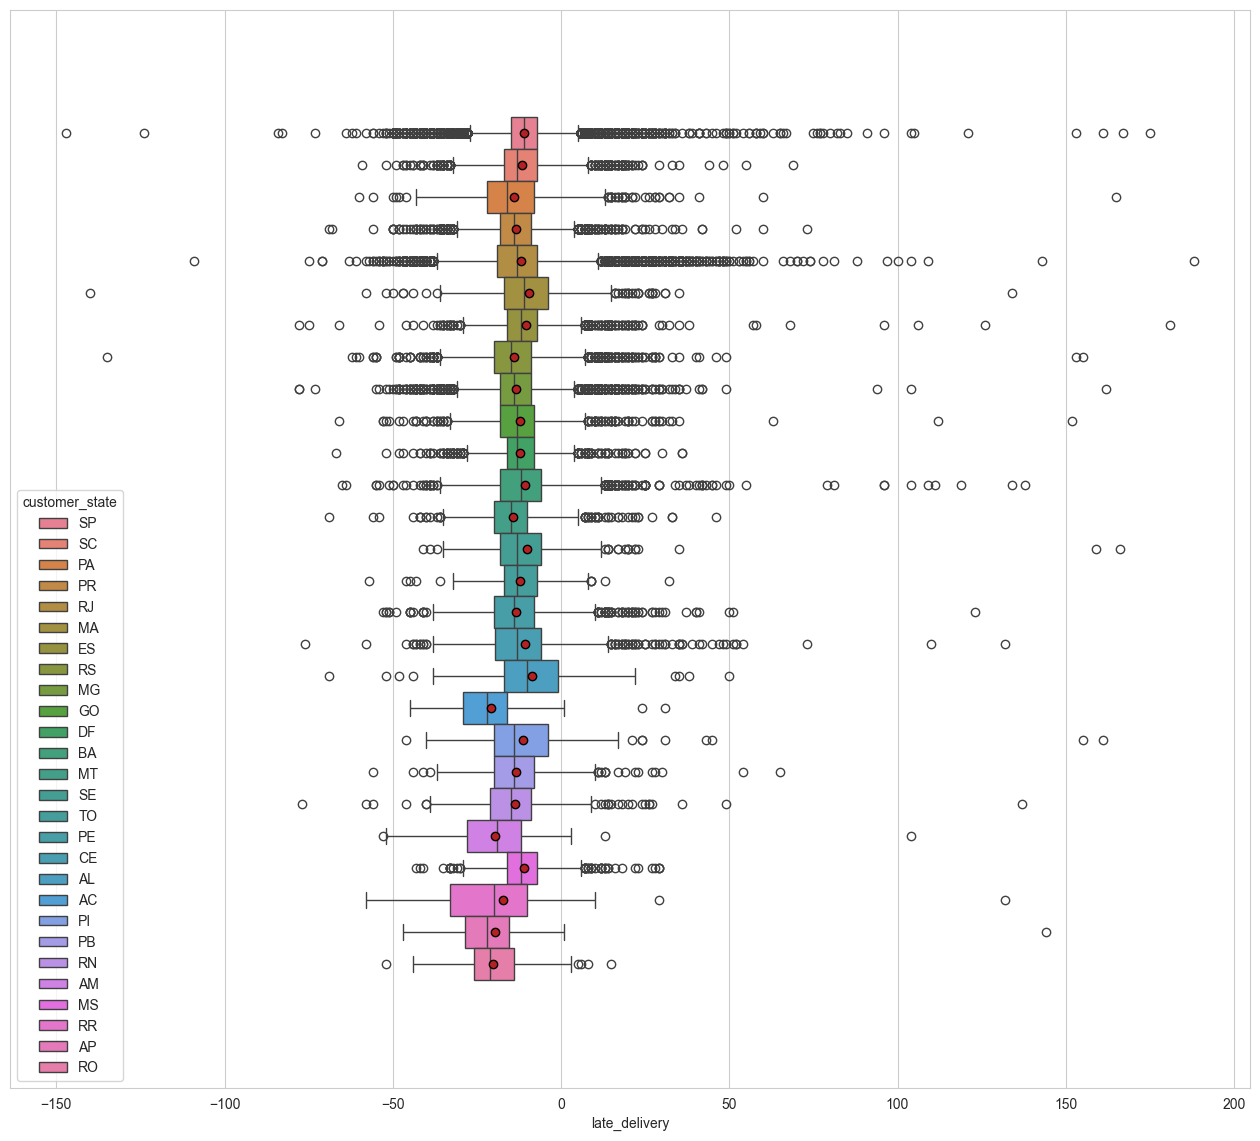

In [69]:
plt.figure(figsize = (16, 14))
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}
sns.boxplot(data=data_fe,x="late_delivery", hue="customer_state", showmeans=True, meanprops=meanprops)
plt.show()

Nous pouvons noter que selon la localisation du client, les délais de livraison estimés et réels peuvent être plus importants (ex : PA,AM,RR,AP,...).

Dans certains états, les avances de livraisons sont plus importantes (ex : AC,AM,RR,AP,RO,...).

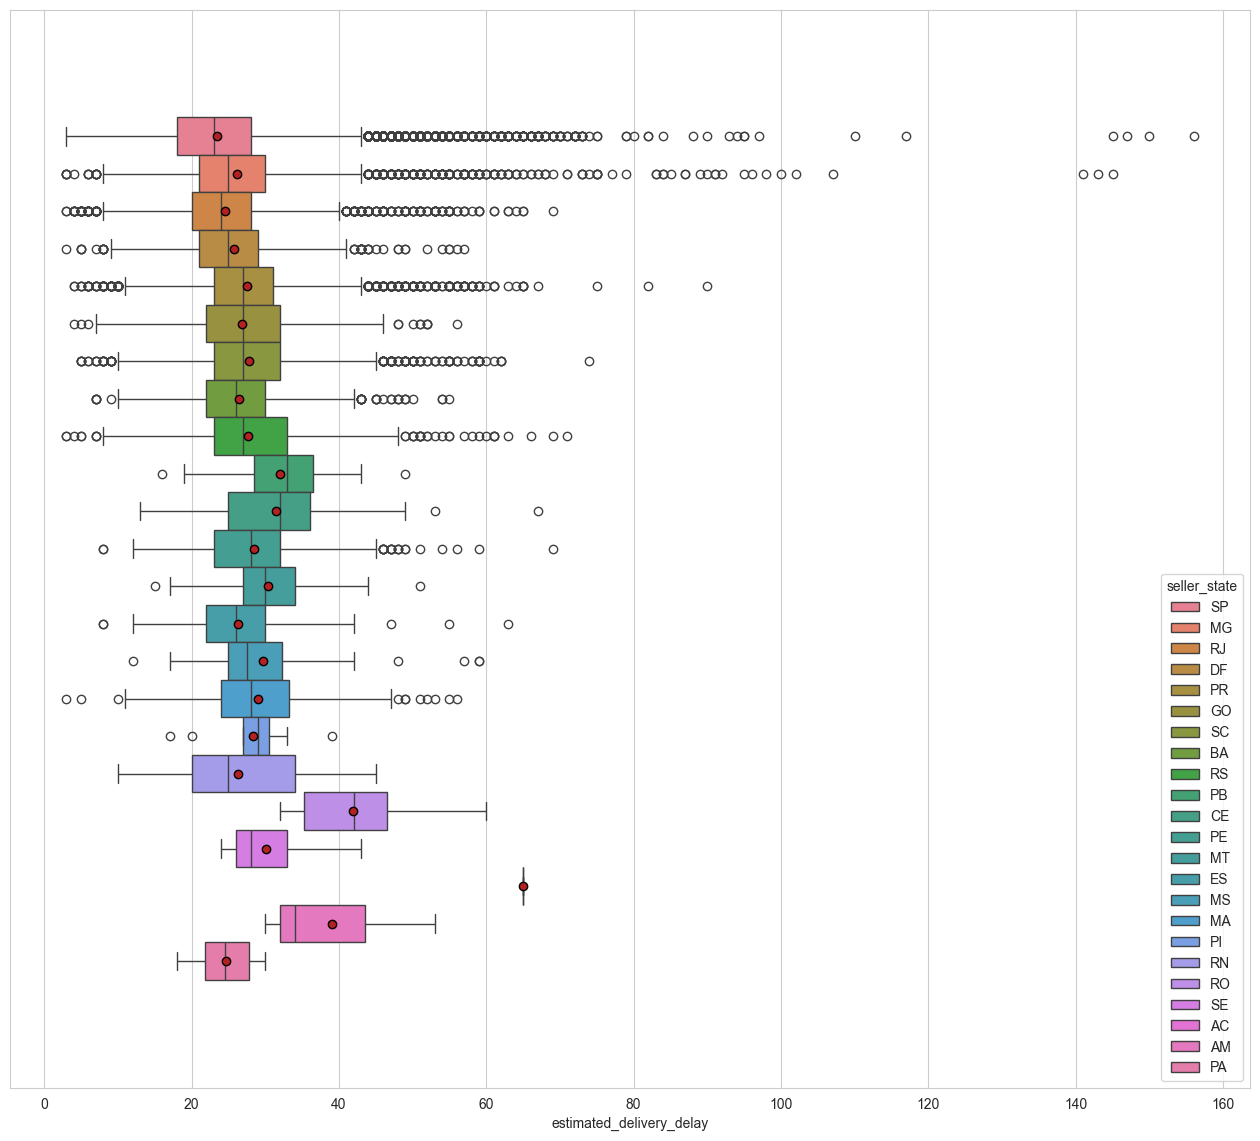

In [70]:
plt.figure(figsize = (16, 14))
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}
sns.boxplot(data=data_fe,x="estimated_delivery_delay", hue="seller_state", showmeans=True, meanprops=meanprops)
plt.show()

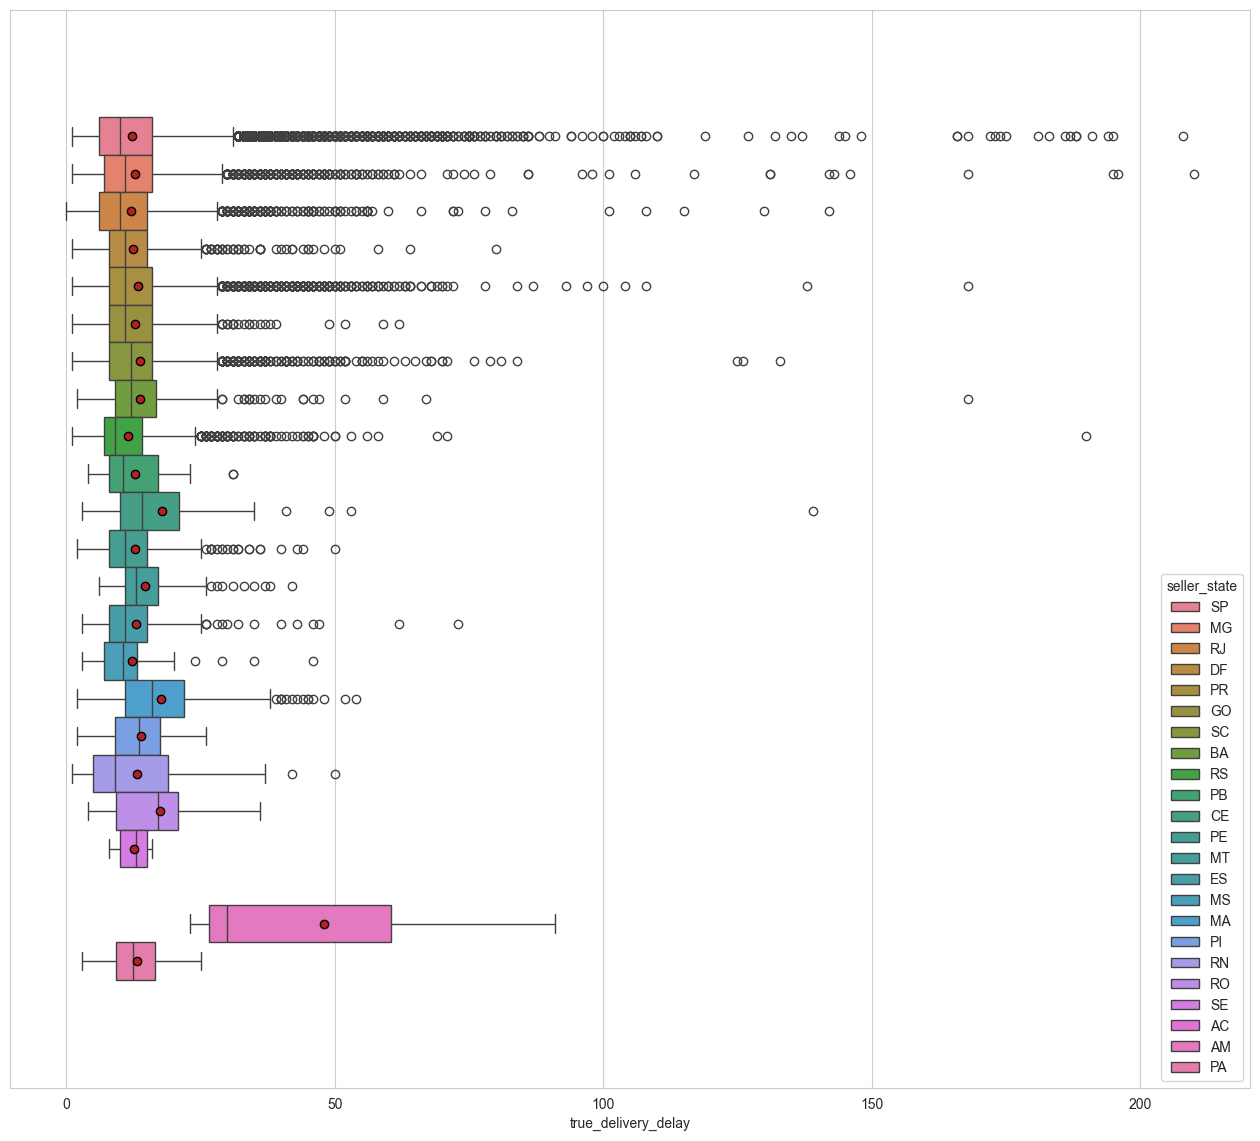

In [71]:
plt.figure(figsize = (16, 14))
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}
sns.boxplot(data=data_fe,x="true_delivery_delay", hue="seller_state", showmeans=True, meanprops=meanprops)
plt.show()

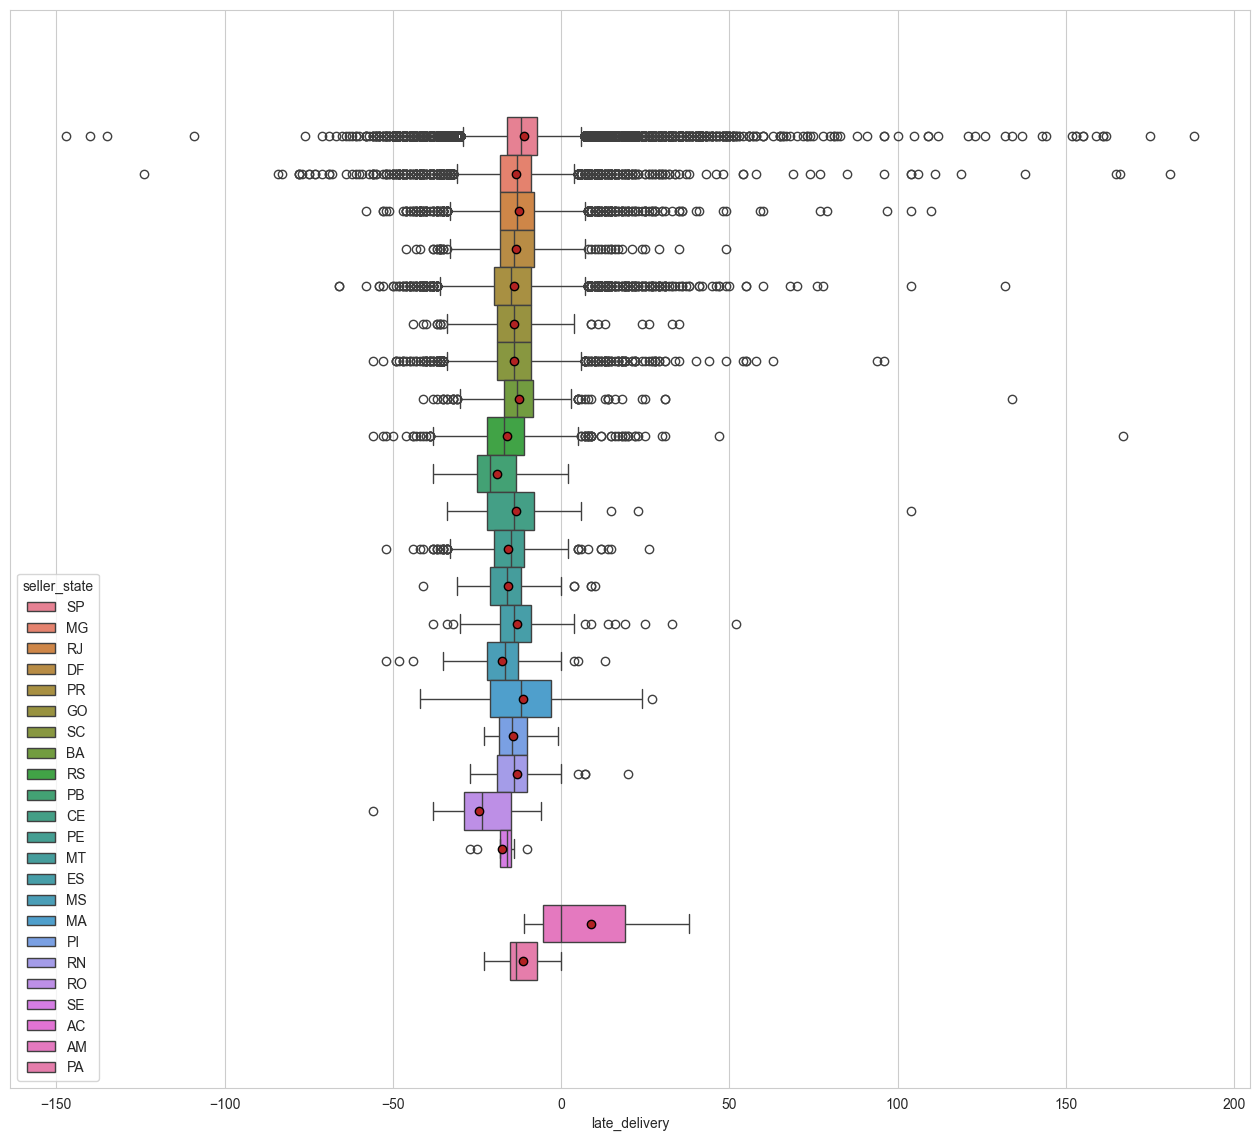

In [72]:
plt.figure(figsize = (16, 14))
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}
sns.boxplot(data=data_fe,x="late_delivery", hue="seller_state", showmeans=True, meanprops=meanprops)
plt.show()

Nous pouvons noter que selon la localisation du vendeur, les délais de livraison estimés sont plus importants (AM,AC,RO) mais seuls les dates de livraison réelles de AM sont plus importantes que les autres.On retrouve donc logiquement un plus important retard de livraison pour cette région AM, comparé aux autres.

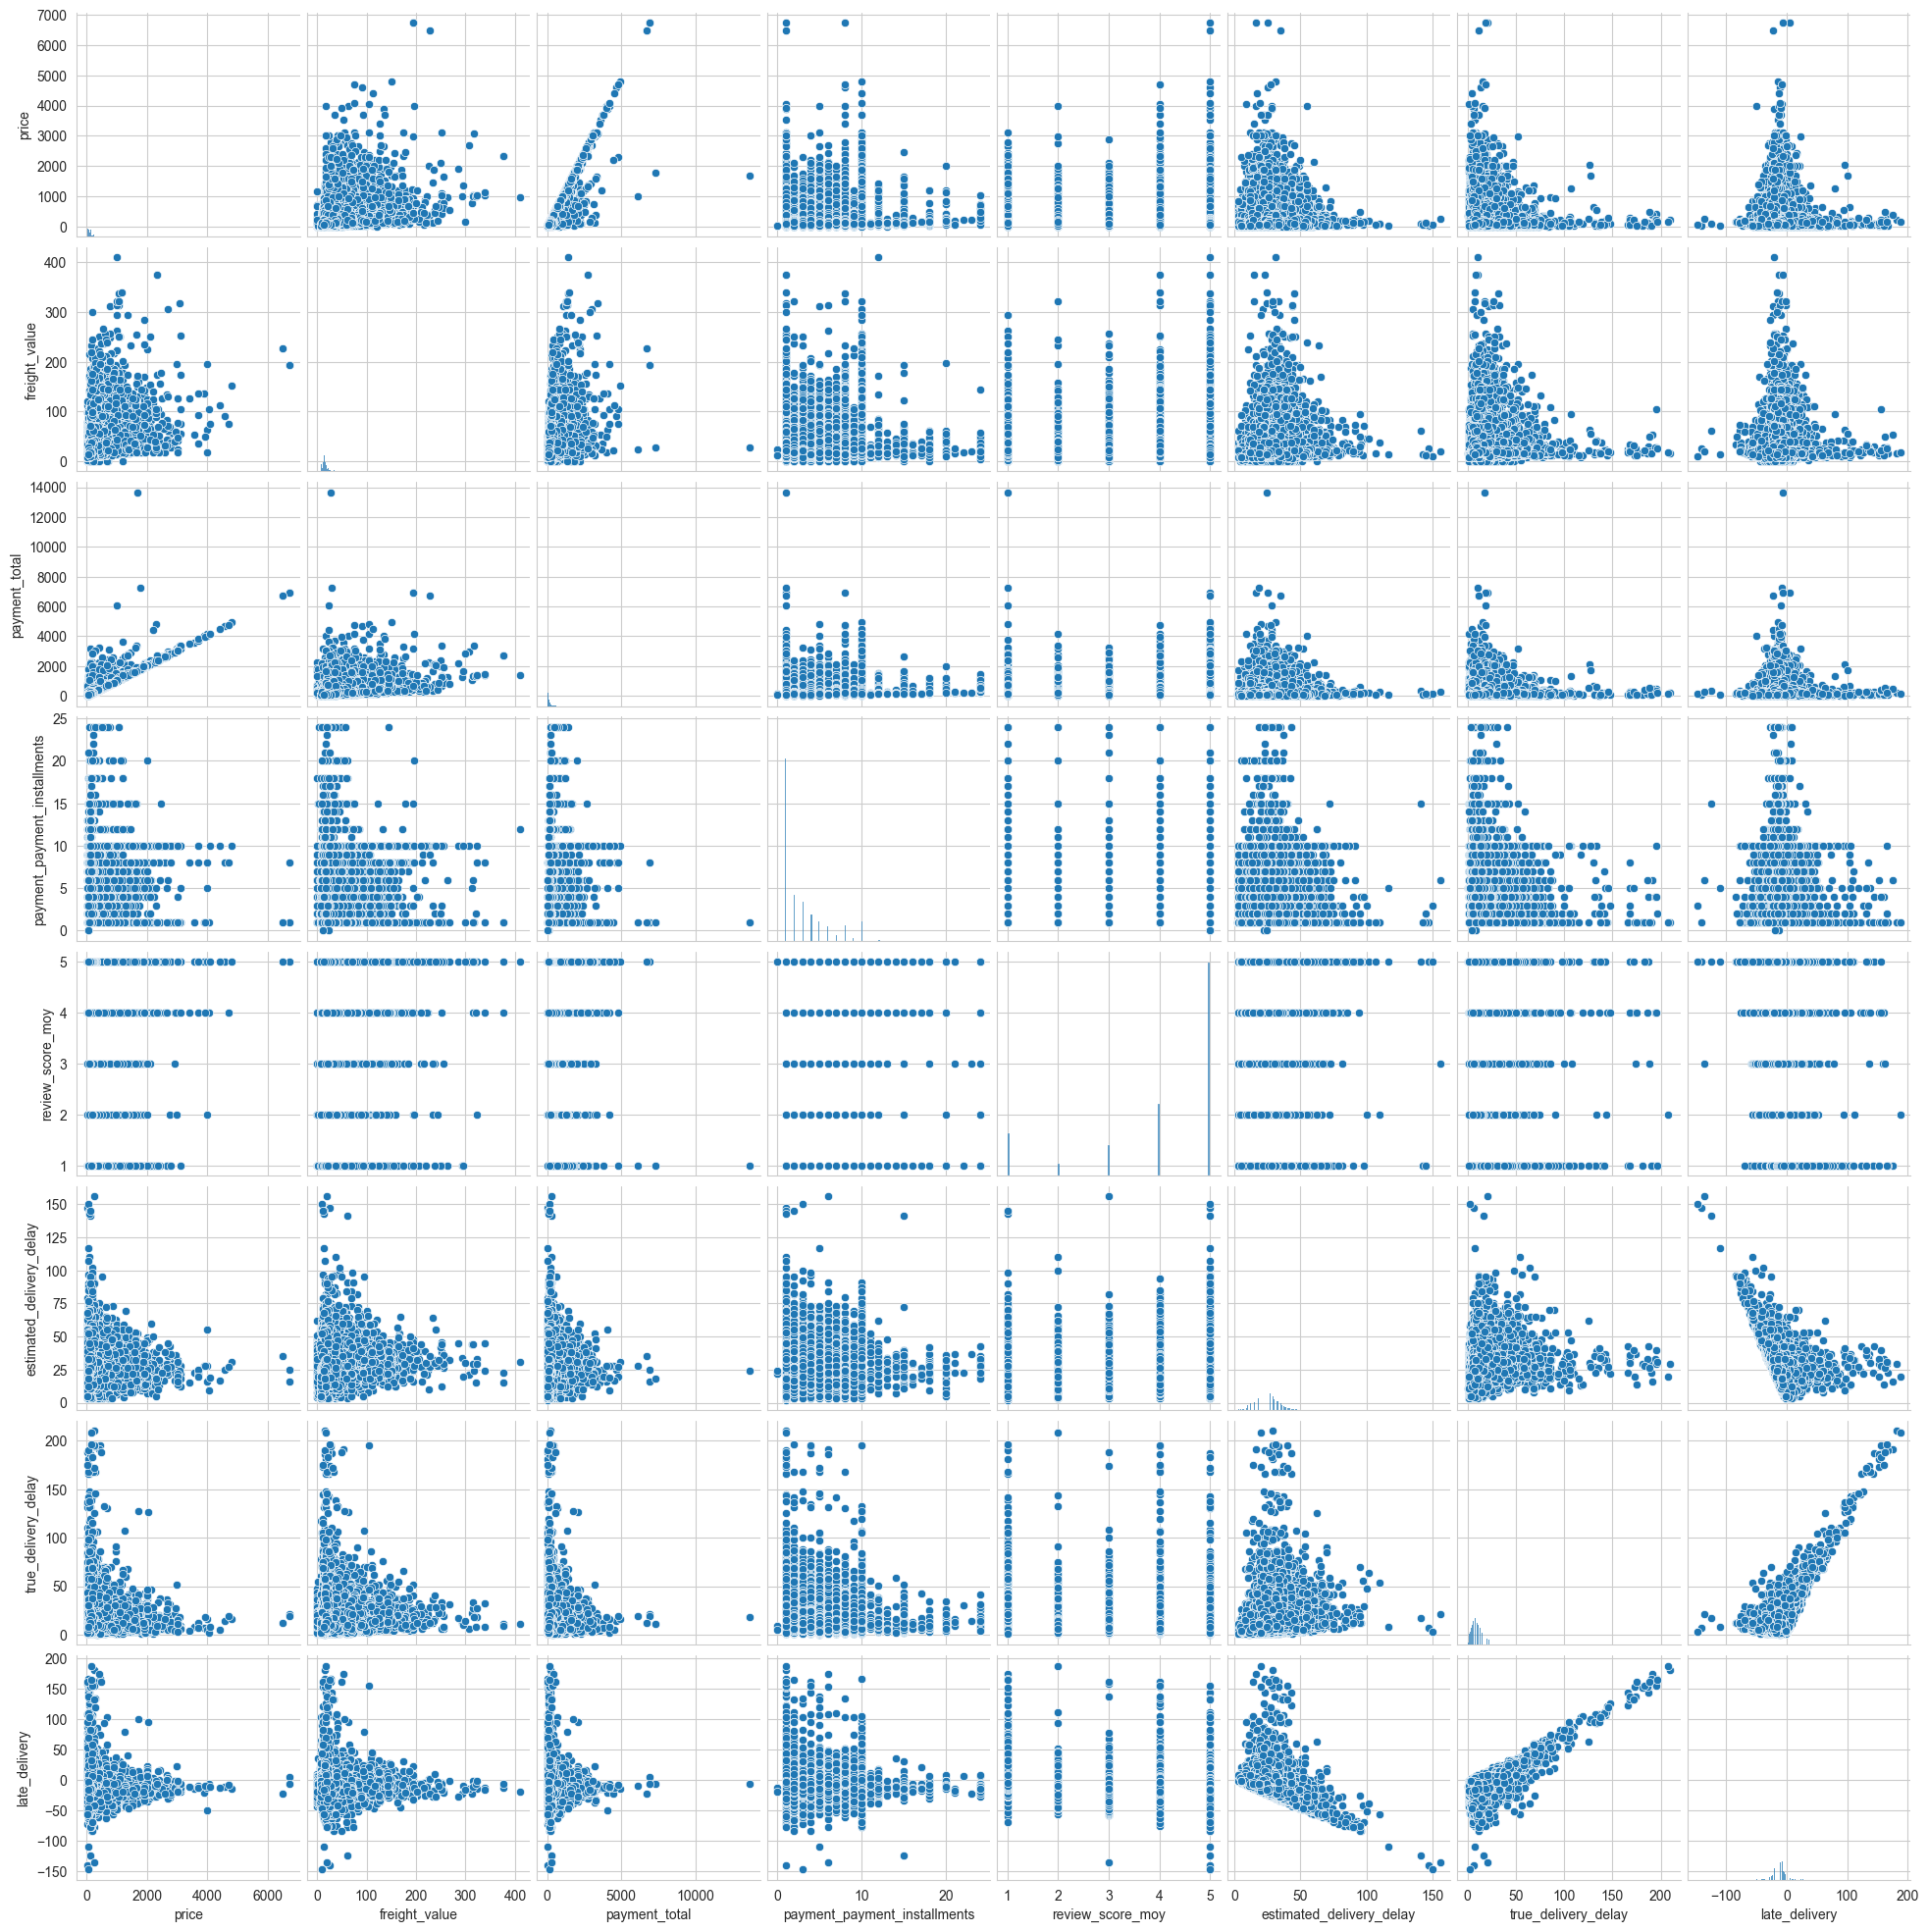

In [73]:
sns.pairplot(data_fe[['price',	'freight_value',	'payment_total',	'payment_payment_installments',	'review_score_moy','estimated_delivery_delay','true_delivery_delay','late_delivery']])

Nous pouvons remarquer que les plus gros retards ou avances de livraisons sont pour des commandes peu coûteuses.

Concernant les notes clients, lorsque la livraison a beaucoup d'avance, cela conduit à des notes plus importantes, et inversement pour les gros retards de livraisons qui conduisent à des notes plus basses.


In [74]:
data_fe.to_csv('D:/tutorial-env/OCR/Projet5/data_fe.csv', index=False)

Création d'un csv issu du feature engineering mais regroupé par client, donc avec moins de variables :

In [75]:
data_fe_client = data_fe.groupby("customer_unique_id", as_index=False)\
                  .agg({"order_id": "nunique",
                  "estimated_delivery_delay": "mean",
                  "true_delivery_delay": "mean",
                  "late_delivery": "mean",
                  "price": "sum",
                  "freight_value": "sum",
                  "payment_total": "sum",
                  "payment_payment_installments": "mean",
                  "review_score_moy": "mean"
                  # ,
                  # "order_purchase_month": lambda x:x.value_counts().index[0]
                        })

In [76]:
data_fe_client

customer_unique_id  order_id  estimated_delivery_delay  \
0      0000366f3b9a7992bf8c76cfdf3221e2         1                      11.0   
1      0000b849f77a49e4a4ce2b2a4ca5be3f         1                       8.0   
2      0000f46a3911fa3c0805444483337064         1                      28.0   
3      0000f6ccb0745a6a4b88665a16c9f078         1                      32.0   
4      0004aac84e0df4da2b147fca70cf8255         1                      21.0   
...                                 ...       ...                       ...   
96091  fffcf5a5ff07b0908bd4e2dbc735a684         1                      55.0   
96092  fffea47cd6d3cc0a88bd621562a9d061         1                      33.0   
96093  ffff371b4d645b6ecea244b27531430a         1                      45.0   
96094  ffff5962728ec6157033ef9805bacc48         1                      26.0   
96095  ffffd2657e2aad2907e67c3e9daecbeb         1                      24.0   

       true_delivery_delay  late_delivery   price  freight_value  \
0                      6.0           -5.0  129.90          12.00   
1                      3.0           -5.0   18.90           8.29   
2                     26.0           -2.0   69.00          17.22   
3                     20.0          -12.0   25.99          17.63   
4                     13.0           -8.0  180.00          16.89   
...                    ...            ...     ...            ...   
96091                 28.0          -27.0  680.00         239.14   
96092                 30.0           -3.0   64.89          19.69   
96093                 15.0          -30.0   89.90          22.56   
96094                 12.0          -14.0  115.00          18.69   
96095                  8.0          -16.0   56.99          14.57   

       payment_total  payment_payment_installments  review_score_moy  
0             141.90                           8.0               5.0  
1              27.19                           1.0               4.0  
2              86.22                           8.0               3.0  
3              43.62                           4.0               4.0  
4             196.89                           6.0               5.0  
...              ...                           ...               ...  
96091        2067.42                          10.0               5.0  
96092          84.58                           1.0               4.0  
96093         112.46                           1.0               5.0  
96094         133.69                           5.0               5.0  
96095          71.56                           4.0               5.0  

[96096 rows x 10 columns]

In [77]:
data_fe_client.describe(include="all")

customer_unique_id      order_id  \
count                              96096  96096.000000   
unique                             96096           NaN   
top     0000366f3b9a7992bf8c76cfdf3221e2           NaN   
freq                                   1           NaN   
mean                                 NaN      1.034809   
std                                  NaN      0.214384   
min                                  NaN      1.000000   
25%                                  NaN      1.000000   
50%                                  NaN      1.000000   
75%                                  NaN      1.000000   
max                                  NaN     17.000000   

        estimated_delivery_delay  true_delivery_delay  late_delivery  \
count               96096.000000         93356.000000   93356.000000   
unique                       NaN                  NaN            NaN   
top                          NaN                  NaN            NaN   
freq                         NaN                  NaN            NaN   
mean                   24.387204            12.507146     -11.849300   
std                     8.780618             9.555496      10.140626   
min                     2.000000             0.000000    -147.000000   
25%                    19.000000             7.000000     -17.000000   
50%                    24.000000            10.000000     -12.000000   
75%                    29.000000            16.000000      -7.000000   
max                   156.000000           210.000000     188.000000   

               price  freight_value  payment_total  \
count   96096.000000   96096.000000   96096.000000   
unique           NaN            NaN            NaN   
top              NaN            NaN            NaN   
freq             NaN            NaN            NaN   
mean      129.249774      20.719091     166.592492   
std       196.690366      16.704279     231.428332   
min         0.000000       0.000000       0.000000   
25%        42.000000      13.370000      63.120000   
50%        79.900000      16.600000     108.000000   
75%       144.000000      22.110000     183.530000   
max      7388.000000     409.680000   13664.080000   

        payment_payment_installments  review_score_moy  
count                   96095.000000      95380.000000  
unique                           NaN               NaN  
top                              NaN               NaN  
freq                             NaN               NaN  
mean                        2.902892          4.084811  
std                         2.687117          1.341711  
min                         0.000000          1.000000  
25%                         1.000000          4.000000  
50%                         2.000000          5.000000  
75%                         4.000000          5.000000  
max                        24.000000          5.000000

In [78]:
data_fe_client.to_csv('D:/tutorial-env/OCR/Projet5/data_fe_client.csv', index=False)